<a href="https://colab.research.google.com/github/meedastitou/computer-vision/blob/main/gridSearchYolov8L.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Wed May 21 14:57:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 98.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstallin

In [ ]:
import os
import yaml
import numpy as np
import pandas as pd
from itertools import product
from ultralytics import YOLO
import time
import json
from datetime import datetime
from torch import torch
import gc


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

class CFG:
    DEBUG = False
    SEED = 42
    DATASET_PATH = '/content/drive/MyDrive/dataset'
    NAME = 'detection-PPEv7'
    CLASSES = ['Gloves', 'Glasses', 'Shoes', 'Helmet', 'Vest', 'Person']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)
    NUM_CORES = 2

    # Base training parameters
    EPOCHS = 3 if DEBUG else 20  # Reduced for grid search
    BATCH_SIZE = 16
    OPTIMIZER = 'AdamW'  # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    WEIGHT_DECAY = 5e-4
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # Model
    YOLO_MODEL = "yolov8l.pt"

    # Output
    OUTPUT_DIR = "/content/drive/MyDrive/PPE-detection/runs"
    ARTIFACTS = '/content/drive/MyDrive/PPE-detection/artifacts'
    GRIDSEARCH_DIR = '/content/drive/MyDrive/PPE-detection/gridsearch/yolov8l'

    # GridSearch parameters
    PARAM_GRID = {
        'lr': [1e-4, 5e-4, 1e-3, 3e-3],
        'optimizer': ['SGD', 'AdamW', 'Adam', 'RMSProp'],
        'batch_size': [32, 16, 8]
    }


In [ ]:
def ensure_dir(dir_path):
    """Create directory if it doesn't exist."""
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print(f"Created directory: {dir_path}")

In [ ]:



def run_gridsearch():
    """Run grid search for YOLO training."""
    # Ensure directories exist
    ensure_dir(CFG.OUTPUT_DIR)
    ensure_dir(CFG.ARTIFACTS)
    ensure_dir(CFG.GRIDSEARCH_DIR)

    # Create parameter combinations
    param_keys = list(CFG.PARAM_GRID.keys())
    param_values = list(CFG.PARAM_GRID.values())
    param_combinations = list(product(*param_values))

    # Create results dataframe
    results = []

    # Generate a timestamp for this grid search run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = os.path.join(CFG.GRIDSEARCH_DIR, f"gridsearch_results_{timestamp}.csv")

    print(f"Starting grid search with {len(param_combinations)} combinations")

    # Run training for each parameter combination
    for i, combination in enumerate(param_combinations):
        params = dict(zip(param_keys, combination))

        # Create a unique run name
        run_name = f"{CFG.NAME}_gs_{i+1}_{'_'.join([f'{k}_{v}' for k, v in params.items()])}"
        run_name = run_name.replace('.', '')  # Remove dots from name for filesystem compatibility

        print(f"\n{'='*80}")
        print(f"Running combination {i+1}/{len(param_combinations)}")
        print(f"Parameters: {params}")
        print(f"{'='*80}\n")

        # Load base model
        model = YOLO(CFG.YOLO_MODEL)

        # Set up training parameters
        train_args = {
            'data': os.path.join(CFG.DATASET_PATH, 'data.yaml'),
            'epochs': CFG.EPOCHS,
            'imgsz': 640,
            'batch': params['batch_size'],
            'device': 0,
            'workers': CFG.NUM_CORES,
            'project': CFG.OUTPUT_DIR,
            'name': run_name,
            'seed': CFG.SEED,
            'optimizer': params['optimizer'],
            'lr0': params['lr'],  # Initial learning rate
            'weight_decay': CFG.WEIGHT_DECAY,
            'val': True,
            'amp': True,
            'exist_ok': True,
            'resume': False,
            'verbose': False,
        }

        # Start timer
        start_time = time.time()

        # Train model
        results_obj = model.train(**train_args)

        # End timer
        training_time = time.time() - start_time

        # Get metrics
        metrics = {
            'map50': float(results_obj.results_dict.get('metrics/mAP50(B)', 0)),
            'map50_95': float(results_obj.results_dict.get('metrics/mAP50-95(B)', 0)),
            'precision': float(results_obj.results_dict.get('metrics/precision(B)', 0)),
            'recall': float(results_obj.results_dict.get('metrics/recall(B)', 0)),
            'train_time': training_time
        }

        # Add results to list
        result_dict = {**params, **metrics}
        results.append(result_dict)

        # Save intermediate results
        pd.DataFrame(results).to_csv(results_file, index=False)
        print(f"Saved intermediate results to {results_file}")

        # Print current best model based on mAP50-95
        if results:
            df = pd.DataFrame(results)
            best_idx = df['map50_95'].idxmax()
            best_params = df.loc[best_idx].to_dict()
            print("\nCurrent best model:")
            print(f"Parameters: {json.dumps({k: best_params[k] for k in param_keys}, indent=2)}")
            print(f"mAP50-95: {best_params['map50_95']:.4f}")
            print(f"mAP50: {best_params['map50']:4f}")
            print(f"Precision: {best_params['precision']:.4f}")
            print(f"Recall: {best_params['recall']:.4f}")
            print(f"Training time: {best_params['train_time']:.2f} seconds")
        del model
        del results_obj
        torch.cuda.empty_cache()
        gc.collect()
        print(f"{'='*80}\n")

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    # Save final results
    results_df.to_csv(results_file, index=False)

    # Find best parameters
    best_idx = results_df['map50_95'].idxmax()
    best_params = results_df.loc[best_idx].to_dict()

    # Create summary file
    summary_file = os.path.join(CFG.GRIDSEARCH_DIR, f"gridsearch_summary_{timestamp}.txt")

    with open(summary_file, 'w') as f:
        f.write(f"Grid Search Summary for {CFG.NAME}\n")
        f.write(f"Timestamp: {timestamp}\n")
        f.write(f"Total combinations: {len(param_combinations)}\n\n")

        f.write("Parameter grid:\n")
        for param, values in CFG.PARAM_GRID.items():
            f.write(f"  {param}: {values}\n")

        f.write("\nBest parameters:\n")
        for param in param_keys:
            f.write(f"  {param}: {best_params[param]}\n")

        f.write("\nBest metrics:\n")
        f.write(f"  mAP50-95: {best_params['map50_95']:.4f}\n")
        f.write(f"  mAP50: {best_params['map50']:.4f}\n")
        f.write(f"  Precision: {best_params['precision']:.4f}\n")
        f.write(f"  Recall: {best_params['recall']:.4f}\n")
        f.write(f"  Training time: {best_params['train_time']:.2f} seconds\n")

    print(f"\nGrid search completed. Results saved to {results_file}")
    print(f"Summary saved to {summary_file}")

    return best_params


In [ ]:

def visualize_results(results_file):
    """Visualize grid search results."""
    # Load results
    results_df = pd.DataFrame(pd.read_csv(results_file))

    # Create plots directory
    plots_dir = os.path.join(CFG.GRIDSEARCH_DIR, 'plots')
    ensure_dir(plots_dir)

    # Import visualization libraries
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Set plot style
    plt.style.use('ggplot')

    # 1. Learning rate vs mAP50-95 for different optimizers
    plt.figure(figsize=(12, 8))
    for optimizer in results_df['optimizer'].unique():
        data = results_df[results_df['optimizer'] == optimizer]
        plt.plot(data['lr'], data['map50'], marker='o', label=optimizer)

    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('mAP50')
    plt.title('Learning Rate vs mAP50 for Different Optimizers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plot_path = os.path.join(plots_dir, 'lr_vs_map.png')
    plt.savefig(plot_path)

    # 2. Heatmap of mAP50-95 for different optimizers and learning rates
    for batch_size in results_df['batch_size'].unique():
        plt.figure(figsize=(10, 6))
        pivot_df = results_df[results_df['batch_size'] == batch_size].pivot_table(
            index='optimizer', columns='lr', values='map50'
        )
        sns.heatmap(pivot_df, annot=True, cmap='viridis', fmt='.4f')
        plt.title(f'mAP50 for Different Optimizers and Learning Rates (Batch Size: {batch_size})')
        plt.tight_layout()
        plot_path = os.path.join(plots_dir, f'heatmap_batch_{batch_size}.png')
        plt.savefig(plot_path)

    # 3. Training time comparison
    plt.figure(figsize=(12, 6))
    sns.barplot(x='optimizer', y='train_time', hue='batch_size', data=results_df)
    plt.title('Training Time Comparison')
    plt.xlabel('Optimizer')
    plt.ylabel('Training Time (seconds)')
    plt.grid(True, axis='y')
    plt.tight_layout()
    plot_path = os.path.join(plots_dir, 'training_time.png')
    plt.savefig(plot_path)

    print(f"Visualizations saved to {plots_dir}")




In [ ]:
def train_with_best_params(best_params):
    """Train a final model with the best parameters found from grid search."""
    print("\nTraining final model with best parameters...")

    # Create a unique run name for the final model
    run_name = f"{CFG.NAME}_final_{'_'.join([f'{k}_{v}' for k, v in best_params.items() if k in CFG.PARAM_GRID.keys()])}"
    run_name = run_name.replace('.', '')  # Remove dots for filesystem compatibility

    # Load base model
    model = YOLO(CFG.YOLO_MODEL)

    # Set up training parameters with the full number of epochs
    train_args = {
        'data': os.path.join(CFG.DATASET_PATH, 'data.yaml'),
        'epochs': 100,
        'imgsz': 640,
        'batch': best_params['batch_size'],
        'device': 0,
        'workers': CFG.NUM_CORES,
        'project': CFG.OUTPUT_DIR,
        'name': run_name,
        'seed': CFG.SEED,
        'optimizer': best_params['optimizer'],
        'lr0': best_params['lr'],  # Initial learning rate
        'weight_decay': CFG.WEIGHT_DECAY,
        'val': True,
        'amp': True,
        'exist_ok': False,
        'resume': False,
        'verbose': False,
        'patience': CFG.PATIENCE,  # Early stopping patience
    }

    # Train model
    results = model.train(**train_args)

    print(f"\nFinal model training completed.")
    print(f"Model saved to {os.path.join(CFG.OUTPUT_DIR, run_name)}")

    return results


Starting grid search with 48 combinations

Running combination 1/48
Parameters: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 32}



100%|██████████| 83.7M/83.7M [00:00<00:00, 344MB/s]


Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/drive/MyDrive/dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8l.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=detection-PPEv7_gs_1_lr_00001_optimizer_SGD_batch_size_32, nbs=64, nms=False, opset=None, optimize=False, optimizer=SGD, overlap_mask=True, pa

100%|██████████| 755k/755k [00:00<00:00, 94.6MB/s]

Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics

  8                  -1  3   4461568  ultralytics.nn.modules.block.C2f             [512, 512, 3, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   4723712  ultralytics.nn.modules.block.C2f             [1024, 512, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 15                  -1  3   1247744  ultralytics.nn.modules.block.C2f             [768, 256, 3]                 
 16                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256,

100%|██████████| 5.35M/5.35M [00:00<00:00, 225MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.5±0.3 ms, read: 0.1±0.0 MB/s, size: 55.2 KB)


train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.4±0.0 ms, read: 0.0±0.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_1_lr_00001_optimizer_SGD_batch_size_32/labels.jpg... 
optimizer: SGD(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_1_lr_00001_optimizer_SGD_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20        18G      1.491      3.528      1.624         63        640: 100%|██████████| 82/82 [30:13<00:00, 22.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.36s/it]

                   all        114        286      0.294      0.195      0.222       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.4G      1.411       2.41       1.58         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.14it/s]

                   all        114        286      0.328      0.227      0.262      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.6G      1.264      1.889       1.47         88        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all        114        286      0.626      0.405      0.459      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.6G      1.121      1.559      1.369         84        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        286      0.661       0.53      0.561      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.6G      1.074      1.378      1.324         50        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        114        286      0.753      0.594      0.648      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.6G      1.036      1.278      1.289         65        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        114        286      0.784      0.628      0.698      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.6G      1.025      1.217       1.27         81        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        286      0.824      0.652      0.727      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.5G     0.9961      1.142      1.248        163        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.789      0.676       0.74      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.6G     0.9863      1.124      1.239        105        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286      0.846      0.672      0.751      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.6G     0.9888      1.079      1.237         36        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286      0.811       0.71      0.757      0.432


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.5G       1.03      1.102      1.255         40        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.885      0.674       0.77      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.5G      1.013       1.07      1.237         42        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286       0.86      0.699      0.779      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.4G      1.007      1.051       1.24         43        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.905       0.68      0.783       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.3G      1.004      1.028      1.232         29        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286      0.897      0.684      0.785      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.3G     0.9883      1.007      1.225         22        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286      0.903      0.676      0.786      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.4G     0.9913     0.9877      1.221         56        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.914      0.682      0.792      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.5G     0.9865     0.9758      1.221         69        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.915      0.685      0.794      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.4G     0.9802     0.9686      1.209         51        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.907      0.696      0.795      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.3G     0.9818      0.968      1.218         34        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286       0.86      0.727      0.798      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.5G     0.9784     0.9666      1.213         31        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.908       0.69      0.797      0.463



20 epochs completed in 0.956 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_1_lr_00001_optimizer_SGD_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_1_lr_00001_optimizer_SGD_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_1_lr_00001_optimizer_SGD_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


                   all        114        286       0.86      0.728      0.798      0.465
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_1_lr_00001_optimizer_SGD_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "SGD",
  "batch_size": 32
}
mAP50-95: 0.4648
mAP50: 0.797723
Precision: 0.8601
Recall: 0.7280
Training time: 3497.20 seconds


Running combination 2/48
Parameters: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 16}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mo

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.6±0.7 ms, read: 11.4±11.3 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_2_lr_00001_optimizer_SGD_batch_size_16/labels.jpg... 
optimizer: SGD(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_2_lr_00001_optimizer_SGD_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.11G      1.489      3.331      1.635         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        114        286      0.278      0.197       0.22      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.5G       1.37      2.333      1.558        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        114        286      0.289      0.231      0.273      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.6G       1.24      1.849      1.455         72        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.44it/s]

                   all        114        286      0.609      0.462      0.494      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.6G      1.125      1.556      1.372         83        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        114        286      0.673      0.551      0.571      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.6G      1.075      1.395      1.322         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        114        286      0.774      0.594      0.646      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.6G      1.045      1.293      1.295         47        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        114        286      0.784      0.628       0.69      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.6G      1.016      1.223      1.275         92        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        114        286      0.887      0.585      0.711      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.6G      1.017      1.184      1.264         59        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        114        286      0.849      0.635      0.731      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.6G      1.004      1.146      1.254         69        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]

                   all        114        286      0.865      0.628      0.742      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.6G     0.9696      1.098      1.236         62        640: 100%|██████████| 163/163 [01:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        114        286      0.887       0.62      0.751      0.417


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.6G      1.031      1.116      1.259         42        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        114        286      0.896      0.645      0.764      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.6G      1.016      1.095      1.252         45        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        114        286      0.858      0.678      0.768      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.6G      1.003      1.065      1.245         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        114        286      0.894      0.673      0.778      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.6G      1.004      1.041      1.234         31        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.902      0.677      0.782       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.6G      0.996       1.02      1.234         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.926      0.653      0.785      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.6G      1.002      1.014      1.232         55        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286       0.91      0.672      0.783      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.6G      0.991     0.9998      1.232         67        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.954      0.657      0.787      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.6G     0.9815     0.9904      1.219         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.921      0.673      0.786      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.6G     0.9873     0.9939      1.226         33        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.947       0.66      0.786      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.6G     0.9824     0.9805      1.223         35        640: 100%|██████████| 163/163 [01:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.942      0.668      0.785      0.461



20 epochs completed in 0.469 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_2_lr_00001_optimizer_SGD_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_2_lr_00001_optimizer_SGD_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_2_lr_00001_optimizer_SGD_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.19it/s]


                   all        114        286      0.947      0.661      0.785      0.466
Speed: 0.3ms preprocess, 10.0ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_2_lr_00001_optimizer_SGD_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "SGD",
  "batch_size": 16
}
mAP50-95: 0.4656
mAP50: 0.785366
Precision: 0.9474
Recall: 0.6610
Training time: 1701.76 seconds


Running combination 3/48
Parameters: {'lr': 0.0001, 'optimizer': 'SGD', 'batch_size': 8}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 35.6±22.5 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_3_lr_00001_optimizer_SGD_batch_size_8/labels.jpg... 
optimizer: SGD(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_3_lr_00001_optimizer_SGD_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.98G      1.475      3.219      1.631         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.47it/s]

                   all        114        286      0.283      0.191      0.221      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.52G      1.351      2.312      1.549         66        640: 100%|██████████| 325/325 [01:14<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.84it/s]

                   all        114        286      0.365      0.268      0.289      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.84G      1.237      1.849      1.453         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]

                   all        114        286      0.636      0.473      0.487      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.84G      1.127      1.586      1.376        102        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]

                   all        114        286      0.671      0.555      0.595      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.84G      1.077       1.44      1.331         31        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.19it/s]

                   all        114        286      0.763      0.576      0.642      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.84G       1.05      1.342      1.306         39        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.32it/s]

                   all        114        286      0.822      0.591      0.689      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.84G      1.021      1.274      1.286         52        640: 100%|██████████| 325/325 [01:20<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.33it/s]

                   all        114        286      0.817      0.611      0.714      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.84G      1.014      1.222      1.269         81        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]

                   all        114        286      0.795      0.663      0.726      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.85G      1.002      1.182      1.262         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]

                   all        114        286       0.83      0.649      0.742      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.85G     0.9883      1.164      1.249        110        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]

                   all        114        286      0.845       0.67      0.751       0.42


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.85G      1.039      1.177      1.266         42        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]

                   all        114        286      0.893      0.663       0.76      0.427



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.85G      1.022      1.129      1.258         45        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]

                   all        114        286      0.885      0.704       0.77      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.85G       1.01      1.106      1.255         41        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]

                   all        114        286      0.867      0.696      0.774      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.85G      1.012      1.089      1.247         31        640: 100%|██████████| 325/325 [01:19<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]

                   all        114        286      0.928      0.666      0.776      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.85G      1.003      1.064      1.249         21        640: 100%|██████████| 325/325 [01:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]

                   all        114        286      0.924      0.678      0.778      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.85G      1.002      1.057      1.239         55        640: 100%|██████████| 325/325 [01:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]

                   all        114        286      0.889      0.701       0.78      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.85G      1.004      1.037      1.243         67        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]

                   all        114        286        0.9      0.686      0.784      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.85G     0.9984      1.025      1.234         41        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.933      0.668      0.783      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.85G     0.9948      1.034       1.24         33        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.897      0.692      0.782      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.85G     0.9868      1.029      1.231         35        640: 100%|██████████| 325/325 [01:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        114        286      0.933      0.672      0.784      0.454



20 epochs completed in 0.457 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_3_lr_00001_optimizer_SGD_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_3_lr_00001_optimizer_SGD_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_3_lr_00001_optimizer_SGD_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]


                   all        114        286      0.927      0.672      0.783      0.457
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 4.8ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_3_lr_00001_optimizer_SGD_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "SGD",
  "batch_size": 16
}
mAP50-95: 0.4656
mAP50: 0.785366
Precision: 0.9474
Recall: 0.6610
Training time: 1701.76 seconds


Running combination 4/48
Parameters: {'lr': 0.0001, 'optimizer': 'AdamW', 'batch_size': 32}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_m

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 29.3±21.9 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_4_lr_00001_optimizer_AdamW_batch_size_32/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_4_lr_00001_optimizer_AdamW_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.4G      1.144      1.665      1.342         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.689      0.514      0.595      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.5G      1.033      1.074      1.257         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.793      0.676      0.723      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G     0.9945     0.9665      1.224         88        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.825      0.675      0.771      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G     0.9615     0.9181      1.211         84        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286       0.82      0.729      0.795      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G     0.9267     0.8502      1.195         50        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.828      0.731      0.793      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G     0.8868     0.7982      1.165         65        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.865      0.793      0.851      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G     0.8732      0.764      1.158         81        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.862      0.787      0.857      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G     0.8359     0.7014      1.131        163        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.859      0.773      0.838      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G     0.8177     0.6826      1.112        105        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.835      0.798      0.845      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.7G     0.7966     0.6458        1.1         36        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.896      0.802      0.871      0.558


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G     0.8122     0.5819      1.106         40        640: 100%|██████████| 82/82 [01:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.881      0.836      0.889      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G     0.7812     0.5459      1.085         42        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.897      0.792      0.887      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.5G     0.7546     0.5254      1.071         43        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.911       0.84      0.909       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G     0.7238     0.4948      1.054         29        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.928      0.822      0.904      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G     0.6998     0.4685      1.039         22        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.897      0.851       0.91      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.5G     0.6745     0.4422      1.024         56        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.933      0.854      0.911      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G     0.6567     0.4228      1.015         69        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.917      0.839       0.92      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G     0.6369     0.4049     0.9978         51        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.934      0.824      0.908      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G       0.62     0.3906     0.9986         34        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.912      0.852       0.92      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G     0.5963     0.3767     0.9822         31        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.961      0.824      0.922      0.672



20 epochs completed in 0.478 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_4_lr_00001_optimizer_AdamW_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_4_lr_00001_optimizer_AdamW_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_4_lr_00001_optimizer_AdamW_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


                   all        114        286      0.961      0.824      0.922      0.673
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_4_lr_00001_optimizer_AdamW_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 5/48
Parameters: {'lr': 0.0001, 'optimizer': 'AdamW', 'batch_size': 16}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_pas

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.5±0.4 ms, read: 17.4±17.6 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_5_lr_00001_optimizer_AdamW_batch_size_16/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_5_lr_00001_optimizer_AdamW_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.26G      1.141      1.544      1.353         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.786      0.548      0.631      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      1.049      1.119      1.273        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.866      0.659      0.749      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.019      1.029      1.247         72        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.844      0.682      0.797      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G     0.9843     0.9558      1.228         83        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.877      0.699      0.797      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.8G     0.9463      0.887        1.2         21        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.821      0.704       0.81      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.8G     0.9263     0.8429      1.184         47        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.861      0.769      0.818      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.8G     0.8833     0.7844      1.157         92        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.903      0.767      0.838       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.8G     0.8729      0.746      1.141         59        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.889       0.78      0.842      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.8G     0.8521      0.719      1.134         69        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.902      0.783      0.859      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.8G     0.8079     0.6795      1.116         62        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.818      0.831      0.873      0.561


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.8G     0.8266     0.6007      1.117         42        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.909      0.794       0.88       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.8G     0.7987     0.5687      1.102         45        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.936      0.774      0.879      0.588



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.8G      0.769     0.5371      1.086         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.928      0.793        0.9      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.8G     0.7414     0.5028      1.066         31        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286       0.93       0.81      0.912      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.8G     0.7082     0.4787      1.053         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.929      0.831      0.918      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.8G     0.6989     0.4625      1.035         55        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.923      0.852      0.913      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.8G     0.6734     0.4426      1.024         67        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        114        286      0.911       0.85      0.915      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.8G      0.659     0.4205      1.009         41        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        114        286      0.934      0.858       0.92      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.8G     0.6398     0.4138      1.005         33        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.904      0.889      0.925      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.8G      0.619     0.3951     0.9934         35        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.917      0.881      0.927      0.669



20 epochs completed in 0.470 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_5_lr_00001_optimizer_AdamW_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_5_lr_00001_optimizer_AdamW_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_5_lr_00001_optimizer_AdamW_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


                   all        114        286      0.917       0.88      0.927      0.669
Speed: 0.2ms preprocess, 9.5ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_5_lr_00001_optimizer_AdamW_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 6/48
Parameters: {'lr': 0.0001, 'optimizer': 'AdamW', 'batch_size': 8}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 32.5±18.6 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_6_lr_00001_optimizer_AdamW_batch_size_8/labels.jpg... 
optimizer: AdamW(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_6_lr_00001_optimizer_AdamW_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.09G      1.149      1.518      1.372         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        114        286      0.848       0.62      0.672      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.88G       1.06      1.209      1.295         66        640: 100%|██████████| 325/325 [01:14<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.735      0.643      0.691      0.403



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.93G      1.031      1.083      1.261         91        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.727      0.665      0.696      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.94G     0.9959     0.9991      1.246        102        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.767      0.746      0.754      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.94G     0.9597     0.9367      1.226         31        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.812      0.737      0.796      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.94G     0.9348     0.8963      1.211         39        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286       0.84      0.734      0.803      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.94G     0.9071     0.8356      1.188         52        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.817      0.738      0.802      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.97G     0.8835      0.783      1.165         81        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.873      0.787      0.849      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.32G     0.8733     0.7562      1.154         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        114        286      0.834      0.767      0.838      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.32G     0.8317     0.7231      1.134        110        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.875      0.752      0.843      0.559


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.32G     0.8435      0.632      1.128         42        640: 100%|██████████| 325/325 [01:21<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.878      0.767      0.843      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.32G     0.8168     0.6054      1.115         45        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.877      0.775      0.851      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.32G     0.7838     0.5715      1.104         41        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.888        0.8      0.867      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.32G      0.762     0.5438      1.082         31        640: 100%|██████████| 325/325 [01:20<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.883      0.781       0.87        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.32G     0.7312     0.5116      1.066         21        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        114        286      0.874      0.831      0.883      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.32G     0.7197     0.4934      1.054         55        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        114        286      0.887      0.831      0.895      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.32G     0.6987     0.4703      1.042         67        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        114        286      0.925      0.824      0.906      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.32G     0.6743     0.4471      1.027         41        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all        114        286      0.935      0.824      0.909      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.34G     0.6618     0.4414       1.03         33        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.64it/s]

                   all        114        286       0.91      0.848      0.901      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.34G     0.6414     0.4217      1.012         35        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.65it/s]

                   all        114        286      0.942      0.825      0.905      0.639



20 epochs completed in 0.458 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_6_lr_00001_optimizer_AdamW_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_6_lr_00001_optimizer_AdamW_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_6_lr_00001_optimizer_AdamW_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.80it/s]


                   all        114        286      0.942      0.825      0.905       0.64
Speed: 0.3ms preprocess, 9.6ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_6_lr_00001_optimizer_AdamW_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 7/48
Parameters: {'lr': 0.0001, 'optimizer': 'Adam', 'batch_size': 32}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.5±0.5 ms, read: 15.3±12.1 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_7_lr_00001_optimizer_Adam_batch_size_32/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_7_lr_00001_optimizer_Adam_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.5G      1.149      1.662      1.345         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.722      0.471       0.53       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.5G      1.038      1.095      1.274         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286       0.81      0.662      0.747      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G      0.996     0.9864      1.238         88        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.726      0.682      0.731       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G      0.962     0.9266      1.211         84        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.854      0.647       0.74      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G     0.9274     0.8478      1.191         50        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286       0.84      0.736      0.833      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G     0.8916     0.8008      1.176         65        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.889      0.701      0.794      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G     0.8759     0.7678      1.162         81        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.868      0.766      0.827       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G     0.8352     0.7047      1.131        163        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.926      0.725       0.84      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G     0.8153     0.6755      1.112        105        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.886       0.75      0.838       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.7G     0.7993     0.6424      1.105         36        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286       0.95      0.721      0.846      0.591


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G     0.8007     0.5811      1.102         40        640: 100%|██████████| 82/82 [01:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.857      0.816      0.875      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G     0.7812     0.5447      1.088         42        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.851      0.849      0.889      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.6G     0.7542     0.5236      1.069         43        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.867      0.814      0.879      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G     0.7245     0.4936      1.057         29        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.922      0.814      0.884       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G     0.7016     0.4656      1.043         22        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.868      0.858      0.902      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.5G     0.6729     0.4413      1.019         56        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.914      0.828      0.897      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G      0.655     0.4215      1.016         69        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.926      0.846       0.91      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G     0.6381     0.4055     0.9973         51        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.944      0.841       0.91      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G     0.6174     0.3924     0.9927         34        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.883      0.882      0.919      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G     0.5984     0.3793     0.9794         31        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.927      0.843      0.921      0.672



20 epochs completed in 0.478 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_7_lr_00001_optimizer_Adam_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_7_lr_00001_optimizer_Adam_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_7_lr_00001_optimizer_Adam_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


                   all        114        286      0.925      0.845      0.921      0.672
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_7_lr_00001_optimizer_Adam_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 8/48
Parameters: {'lr': 0.0001, 'optimizer': 'Adam', 'batch_size': 16}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.5±0.1 ms, read: 31.0±17.3 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_8_lr_00001_optimizer_Adam_batch_size_16/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_8_lr_00001_optimizer_Adam_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.26G      1.141       1.55      1.353         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.721      0.559      0.611      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      1.051      1.122      1.271        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286       0.86      0.642      0.723      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.002      1.022      1.239         72        640: 100%|██████████| 163/163 [01:22<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.818      0.676      0.765      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G     0.9717     0.9508      1.219         83        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.922      0.717        0.8      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.8G     0.9423     0.8824      1.204         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.862      0.725      0.786      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.8G     0.9218     0.8378       1.18         47        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.906      0.722      0.818      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.8G     0.8846     0.7859       1.16         92        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.883      0.707      0.816       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.8G     0.8705      0.742      1.143         59        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286       0.88      0.775      0.861      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.8G     0.8531     0.7158      1.136         69        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.842       0.79      0.854      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.8G     0.8086     0.6847       1.12         62        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.927      0.801      0.878      0.559


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.8G     0.8242     0.6069      1.117         42        640: 100%|██████████| 163/163 [01:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286       0.85      0.805      0.875      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.8G     0.7929      0.578      1.093         45        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.897      0.803      0.884      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.8G     0.7662     0.5348      1.079         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.934      0.796      0.893      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.8G     0.7464     0.5063      1.057         31        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.938      0.817        0.9      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.8G     0.7095     0.4776      1.044         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.861      0.883      0.902      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.8G     0.6923      0.459      1.032         55        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        286      0.914      0.866      0.913      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.8G     0.6712     0.4428      1.029         67        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.913      0.873      0.915      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.8G     0.6551     0.4216      1.008         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        114        286      0.937      0.865      0.919      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.8G     0.6377     0.4104      1.004         33        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.951      0.853      0.913      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.8G      0.617     0.3936     0.9892         35        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.933       0.87      0.913      0.661



20 epochs completed in 0.472 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_8_lr_00001_optimizer_Adam_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_8_lr_00001_optimizer_Adam_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_8_lr_00001_optimizer_Adam_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.14it/s]


                   all        114        286      0.933      0.871      0.913       0.66
Speed: 0.2ms preprocess, 10.6ms inference, 0.0ms loss, 2.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_8_lr_00001_optimizer_Adam_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 9/48
Parameters: {'lr': 0.0001, 'optimizer': 'Adam', 'batch_size': 8}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.7±0.4 ms, read: 12.6±11.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_9_lr_00001_optimizer_Adam_batch_size_8/labels.jpg... 
optimizer: Adam(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_9_lr_00001_optimizer_Adam_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.18G      1.139      1.523      1.356         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.767      0.563       0.63      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.97G      1.063      1.207      1.293         66        640: 100%|██████████| 325/325 [01:13<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.836      0.654      0.749      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.02G      1.034      1.091      1.264         91        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286       0.77      0.686      0.722      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.02G     0.9948      1.002       1.24        102        640: 100%|██████████| 325/325 [01:16<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.908      0.684      0.777      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.02G     0.9713     0.9555      1.223         31        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.823      0.752      0.797      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.02G      0.935     0.8975      1.199         39        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.831      0.735      0.785       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.06G     0.9091     0.8264      1.176         52        640: 100%|██████████| 325/325 [01:16<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.853      0.733      0.828      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.06G     0.8835     0.7887      1.154         81        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        114        286       0.87      0.785      0.857      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.08G     0.8608     0.7575      1.148         91        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286       0.84      0.775      0.851      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.08G     0.8396     0.7237      1.134        110        640: 100%|██████████| 325/325 [01:16<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.894      0.778      0.859      0.535


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.08G     0.8494     0.6387      1.136         42        640: 100%|██████████| 325/325 [01:17<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.888      0.777      0.868      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.08G     0.8238     0.6063      1.123         45        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286       0.92      0.776       0.86      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.08G     0.7845     0.5708      1.105         41        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.916      0.785      0.863       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.08G     0.7649      0.543      1.083         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.903      0.806      0.887      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.08G      0.737     0.5106      1.068         21        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.853      0.836      0.877      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.08G      0.718     0.4882      1.049         55        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286       0.92      0.783      0.883      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.43G     0.7004     0.4672       1.04         67        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.932      0.834      0.906      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.43G     0.6791     0.4468      1.024         41        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        114        286      0.889       0.85      0.907      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.43G     0.6647     0.4395      1.029         33        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.66it/s]

                   all        114        286      0.894      0.837      0.893      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.43G     0.6408     0.4192      1.011         35        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.953      0.812      0.901      0.626



20 epochs completed in 0.455 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_9_lr_00001_optimizer_Adam_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_9_lr_00001_optimizer_Adam_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_9_lr_00001_optimizer_Adam_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.94it/s]


                   all        114        286       0.89      0.849      0.907      0.633
Speed: 0.2ms preprocess, 8.3ms inference, 0.0ms loss, 4.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_9_lr_00001_optimizer_Adam_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 10/48
Parameters: {'lr': 0.0001, 'optimizer': 'RMSProp', 'batch_size': 32}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_pa

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.7±0.8 ms, read: 20.2±23.6 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_10_lr_00001_optimizer_RMSProp_batch_size_32/labels.jpg... 
optimizer: RMSprop(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_10_lr_00001_optimizer_RMSProp_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      2.133      3.869      2.336         63        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.54s/it]

                   all        114        286    0.00296     0.0863    0.00278    0.00054



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.6G      1.728      2.617      1.912         84        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.36s/it]

                   all        114        286      0.004     0.0808    0.00237   0.000453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G       1.63      2.419      1.812         88        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.87s/it]

                   all        114        286    0.00334      0.107     0.0023   0.000469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G      1.577      2.308      1.745         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.06s/it]

                   all        114        286     0.0242      0.122     0.0246    0.00815



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G      1.522      2.226      1.709         50        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        114        286     0.0585     0.0648     0.0105    0.00365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G      1.446      2.128      1.659         65        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.123     0.0993     0.0412     0.0185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G      1.422       2.06      1.623         81        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.25s/it]

                   all        114        286      0.404      0.116     0.0928     0.0375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G      1.382      1.977      1.598        163        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        114        286      0.129      0.411      0.179     0.0744



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G      1.373      1.955       1.58        105        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        114        286      0.155     0.0988     0.0581     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.7G      1.354       1.89      1.571         36        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        114        286      0.292      0.215      0.172     0.0814


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G      1.389      1.928      1.628         40        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.447      0.234      0.221     0.0901



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G      1.378      1.889      1.618         42        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.01it/s]

                   all        114        286      0.358       0.19      0.162      0.073



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.6G      1.361      1.875      1.608         43        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286      0.438      0.216      0.204     0.0905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G      1.325      1.786      1.576         29        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        286      0.553      0.271      0.286      0.146



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G      1.298      1.733      1.546         22        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.512      0.272      0.313      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.6G      1.284      1.692      1.537         56        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.494      0.364      0.385      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G      1.274      1.657      1.529         69        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.584      0.398      0.434      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.6G      1.243      1.608      1.496         51        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.658      0.449      0.475      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G      1.226      1.556      1.489         34        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.634        0.4      0.434      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.8G      1.201      1.517      1.463         31        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286       0.74      0.474      0.524       0.26



20 epochs completed in 0.476 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_10_lr_00001_optimizer_RMSProp_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_10_lr_00001_optimizer_RMSProp_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_10_lr_00001_optimizer_RMSProp_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


                   all        114        286      0.738      0.474      0.524       0.26
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_10_lr_00001_optimizer_RMSProp_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 11/48
Parameters: {'lr': 0.0001, 'optimizer': 'RMSProp', 'batch_size': 16}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, co

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 24.1±21.9 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_11_lr_00001_optimizer_RMSProp_batch_size_16/labels.jpg... 
optimizer: RMSprop(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_11_lr_00001_optimizer_RMSProp_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       9.3G      2.084      3.325      2.437         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:08<00:00,  2.06s/it]

                   all        114        286      0.335     0.0894    0.00309     0.0008



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      1.762      2.607      2.051        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]

                   all        114        286   0.000715     0.0937   0.000415   0.000152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.707      2.508      1.992         72        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.18s/it]

                   all        114        286    0.00479      0.132     0.0015   0.000451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G      1.633      2.408      1.919         83        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        114        286     0.0315      0.389     0.0406     0.0132



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.9G      1.561      2.314      1.853         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        114        286      0.365      0.105     0.0656     0.0278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.9G      1.503      2.223      1.794         47        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.54it/s]

                   all        114        286      0.419     0.0717     0.0729     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.9G      1.459      2.152      1.754         92        640: 100%|██████████| 163/163 [01:18<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.404      0.107     0.0456     0.0116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.9G      1.423      2.114      1.718         59        640: 100%|██████████| 163/163 [01:18<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        114        286      0.184      0.197      0.112      0.036



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.9G      1.419      2.058      1.711         69        640: 100%|██████████| 163/163 [01:21<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        114        286      0.117      0.217      0.055     0.0162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G      1.368      1.982      1.675         62        640: 100%|██████████| 163/163 [01:18<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.56it/s]

                   all        114        286      0.253      0.118     0.0858     0.0382


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G      1.442      2.044      1.795         42        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        286      0.375      0.289      0.232      0.096



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G      1.421      1.985      1.768         45        640: 100%|██████████| 163/163 [01:21<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.46it/s]

                   all        114        286      0.326      0.208      0.153     0.0715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G      1.394      1.975       1.75         41        640: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        114        286       0.42      0.362      0.284      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G      1.377      1.899      1.722         31        640: 100%|██████████| 163/163 [01:21<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        286      0.404      0.398        0.3      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G      1.352      1.861      1.703         21        640: 100%|██████████| 163/163 [01:20<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.532      0.294      0.321      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G      1.341      1.816      1.689         55        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        114        286       0.42       0.35      0.307      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G      1.311      1.793      1.674         67        640: 100%|██████████| 163/163 [01:21<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.661      0.403      0.436      0.187



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G      1.293      1.736      1.643         41        640: 100%|██████████| 163/163 [01:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.544      0.372      0.382      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G      1.272      1.716      1.632         33        640: 100%|██████████| 163/163 [01:21<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.658      0.489      0.504      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G      1.255      1.652      1.616         35        640: 100%|██████████| 163/163 [01:27<00:00,  1.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.656      0.461      0.504      0.229



20 epochs completed in 0.470 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_11_lr_00001_optimizer_RMSProp_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_11_lr_00001_optimizer_RMSProp_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_11_lr_00001_optimizer_RMSProp_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.22it/s]


                   all        114        286       0.66       0.45      0.506       0.23
Speed: 0.2ms preprocess, 9.3ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_11_lr_00001_optimizer_RMSProp_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 12/48
Parameters: {'lr': 0.0001, 'optimizer': 'RMSProp', 'batch_size': 8}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 3.0±6.0 ms, read: 16.4±13.2 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_12_lr_00001_optimizer_RMSProp_batch_size_8/labels.jpg... 
optimizer: RMSprop(lr=0.0001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_12_lr_00001_optimizer_RMSProp_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.14G      2.122      3.378      2.284         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]

                   all        114        286    0.00842      0.185    0.00589    0.00113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.48G       1.77      2.613        1.9         66        640: 100%|██████████| 325/325 [01:13<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.61it/s]

                   all        114        286      0.362      0.105      0.008    0.00202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.84G      1.706      2.507      1.824         91        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.66it/s]

                   all        114        286      0.157      0.087     0.0745     0.0227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.85G      1.632      2.406      1.772        102        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]

                   all        114        286      0.425     0.0726     0.0338    0.00899



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.85G       1.56      2.345      1.717         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.18it/s]

                   all        114        286     0.0909      0.182     0.0469     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.85G      1.508      2.257      1.671         39        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.01it/s]

                   all        114        286      0.137       0.21     0.0722      0.023



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.85G      1.473       2.18      1.648         52        640: 100%|██████████| 325/325 [01:19<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

                   all        114        286      0.188      0.249      0.149     0.0575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.89G       1.45      2.116      1.621         81        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

                   all        114        286      0.246      0.313      0.184     0.0759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       5.9G      1.405      2.055       1.59         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.319      0.257      0.206     0.0844



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       5.9G      1.379      2.021      1.575        110        640: 100%|██████████| 325/325 [01:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.382      0.178      0.186     0.0732


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20       5.9G      1.437      2.036      1.631         42        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.403      0.228      0.248      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.99G       1.42      1.984      1.615         45        640: 100%|██████████| 325/325 [01:19<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.31it/s]

                   all        114        286      0.476      0.311      0.288      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.99G      1.382      1.958      1.596         41        640: 100%|██████████| 325/325 [01:19<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.38it/s]

                   all        114        286       0.44      0.289      0.272      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.11G      1.361      1.887      1.567         31        640: 100%|██████████| 325/325 [01:15<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.516      0.421      0.408      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.11G      1.326      1.862      1.554         21        640: 100%|██████████| 325/325 [01:19<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.605      0.272      0.345      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.11G      1.329      1.806      1.543         55        640: 100%|██████████| 325/325 [01:15<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.618      0.375      0.403      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.11G      1.309      1.756      1.531         67        640: 100%|██████████| 325/325 [01:19<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.637      0.402      0.475      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.11G      1.277      1.717      1.496         41        640: 100%|██████████| 325/325 [01:19<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.647      0.418      0.467      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.11G      1.252      1.691      1.498         33        640: 100%|██████████| 325/325 [01:19<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.673       0.42      0.458      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.11G      1.236      1.638       1.48         35        640: 100%|██████████| 325/325 [01:15<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.671      0.444      0.501      0.242



20 epochs completed in 0.453 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_12_lr_00001_optimizer_RMSProp_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_12_lr_00001_optimizer_RMSProp_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_12_lr_00001_optimizer_RMSProp_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.15it/s]


                   all        114        286      0.672      0.444        0.5      0.242
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_12_lr_00001_optimizer_RMSProp_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 13/48
Parameters: {'lr': 0.0005, 'optimizer': 'SGD', 'batch_size': 32}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_pa

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.6±0.4 ms, read: 17.8±11.3 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_13_lr_00005_optimizer_SGD_batch_size_32/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_13_lr_00005_optimizer_SGD_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.3G      1.454      3.034      1.602         63        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        114        286      0.274      0.225      0.271      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.4G      1.187      1.714      1.416         84        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        114        286       0.74       0.47       0.58       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.6G      1.054      1.307        1.3         88        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.817      0.636      0.728      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.6G     0.9844      1.083       1.24         84        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.871      0.692      0.762      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.6G      0.962     0.9738       1.21         50        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.838       0.73      0.793      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.6G     0.9284     0.8994      1.192         65        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.916        0.7      0.804       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.6G      0.915     0.8629      1.179         81        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.905      0.745      0.836      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.5G     0.8876     0.8091       1.16        163        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.908      0.748      0.834      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.6G     0.8732     0.7934      1.154        105        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.907      0.765      0.845      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.5G     0.8654     0.7638       1.15         36        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.895      0.744      0.844      0.517


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.5G     0.8804     0.7032      1.153         40        640: 100%|██████████| 82/82 [01:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286       0.89      0.775      0.855      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.5G     0.8658     0.6845      1.137         42        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.897      0.801      0.863      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.4G      0.844     0.6657      1.129         43        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.895      0.781      0.857      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.3G     0.8301     0.6441      1.121         29        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.907        0.8      0.865      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.3G     0.8148     0.6259      1.111         22        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.897       0.81      0.862      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.4G     0.8078      0.609      1.102         56        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.873      0.805      0.865      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.5G     0.8007     0.5975        1.1         69        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.909      0.795       0.87      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.4G      0.788     0.5896      1.087         51        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.898      0.816      0.871      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.3G     0.7826     0.5858       1.09         34        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286       0.89      0.824      0.873      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.5G      0.779     0.5789      1.083         31        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.885      0.813      0.872      0.565



20 epochs completed in 0.472 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_13_lr_00005_optimizer_SGD_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_13_lr_00005_optimizer_SGD_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_13_lr_00005_optimizer_SGD_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


                   all        114        286      0.887      0.816      0.872      0.566
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_13_lr_00005_optimizer_SGD_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 14/48
Parameters: {'lr': 0.0005, 'optimizer': 'SGD', 'batch_size': 16}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_past

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.3±1.3 ms, read: 5.1±5.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_14_lr_00005_optimizer_SGD_batch_size_16/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_14_lr_00005_optimizer_SGD_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       9.1G      1.443      2.861      1.606         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        114        286      0.334      0.268      0.287       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.5G      1.164      1.677      1.402        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.54it/s]

                   all        114        286      0.719      0.574      0.623      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.6G      1.041      1.291      1.292         72        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        114        286      0.803      0.646      0.731      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.6G     0.9917        1.1      1.238         83        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.908      0.653      0.772      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.6G     0.9608       0.99       1.21         21        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.836      0.701      0.787      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.6G     0.9424     0.9315      1.198         47        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.948      0.671      0.801      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.6G     0.9132     0.8736      1.178         92        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.913      0.694      0.814      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.6G     0.9078      0.841      1.168         59        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.907      0.715      0.839      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.6G     0.8943     0.8177      1.164         69        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.912      0.725      0.833      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.6G     0.8565     0.7829      1.147         62        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.864      0.781      0.851       0.51


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.6G     0.8924     0.7247      1.158         42        640: 100%|██████████| 163/163 [01:22<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.864      0.789      0.851       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.6G     0.8746     0.7088      1.147         45        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.913      0.764       0.86      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.6G     0.8521     0.6828      1.138         41        640: 100%|██████████| 163/163 [01:21<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.872       0.78      0.856      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.6G     0.8487      0.658       1.13         31        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.914      0.774      0.863      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.6G     0.8238     0.6378      1.115         21        640: 100%|██████████| 163/163 [01:18<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.951      0.757      0.863      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.6G     0.8201     0.6322      1.108         55        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.919      0.776      0.864      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.6G     0.8205     0.6158      1.112         67        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.918      0.756      0.864      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.6G     0.8058     0.6067      1.093         41        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.895      0.783      0.868      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.6G     0.7982     0.6042      1.097         33        640: 100%|██████████| 163/163 [01:21<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.907      0.783      0.866      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.6G     0.7918     0.5972       1.09         35        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.898      0.781      0.867      0.556



20 epochs completed in 0.461 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_14_lr_00005_optimizer_SGD_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_14_lr_00005_optimizer_SGD_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_14_lr_00005_optimizer_SGD_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.16it/s]


                   all        114        286      0.896      0.783      0.867      0.556
Speed: 0.2ms preprocess, 10.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_14_lr_00005_optimizer_SGD_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 15/48
Parameters: {'lr': 0.0005, 'optimizer': 'SGD', 'batch_size': 8}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.5±2.6 ms, read: 11.4±11.6 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_15_lr_00005_optimizer_SGD_batch_size_8/labels.jpg... 
optimizer: SGD(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_15_lr_00005_optimizer_SGD_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.96G       1.42      2.748      1.595         81        640: 100%|██████████| 325/325 [01:16<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.96it/s]

                   all        114        286      0.453      0.317      0.345      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.72G      1.149      1.674      1.403         66        640: 100%|██████████| 325/325 [01:13<00:00,  4.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

                   all        114        286      0.731       0.56      0.603       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.73G      1.052      1.315      1.302         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.835      0.631      0.737      0.358



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.73G     0.9985       1.13      1.258        102        640: 100%|██████████| 325/325 [01:19<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.824      0.703      0.767      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.76G     0.9713      1.045      1.235         31        640: 100%|██████████| 325/325 [01:19<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.888      0.673      0.784      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.12G     0.9505     0.9708      1.213         39        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.881      0.709      0.808      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.12G     0.9267       0.92      1.201         52        640: 100%|██████████| 325/325 [01:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.893      0.737      0.825      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.12G     0.9186     0.8787      1.179         81        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.889      0.722      0.823      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.12G     0.8989     0.8448      1.169         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.883      0.736      0.829      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.12G     0.8861     0.8331      1.163        110        640: 100%|██████████| 325/325 [01:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.889       0.77      0.836      0.521


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.12G      0.913     0.7655      1.171         42        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.889       0.76       0.84      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.12G     0.8947     0.7386      1.157         45        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286       0.93      0.722      0.848      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.12G     0.8759     0.7088      1.151         41        640: 100%|██████████| 325/325 [01:19<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        114        286      0.866      0.783      0.854      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.12G      0.865     0.6915      1.135         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.911      0.766      0.856      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.12G      0.857     0.6733      1.135         21        640: 100%|██████████| 325/325 [01:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.885      0.781      0.855      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.12G     0.8427     0.6608      1.124         55        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.879      0.768      0.852      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.12G     0.8429     0.6464      1.125         67        640: 100%|██████████| 325/325 [01:16<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.894      0.793      0.854      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.12G     0.8329     0.6374      1.114         41        640: 100%|██████████| 325/325 [01:15<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.872      0.786      0.856      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.12G     0.8272     0.6397      1.122         33        640: 100%|██████████| 325/325 [01:19<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.884      0.785      0.855      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.12G     0.8182     0.6295      1.111         35        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.878      0.773      0.853      0.533



20 epochs completed in 0.449 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_15_lr_00005_optimizer_SGD_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_15_lr_00005_optimizer_SGD_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_15_lr_00005_optimizer_SGD_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.99it/s]


                   all        114        286      0.873      0.786      0.856      0.538
Speed: 0.2ms preprocess, 11.8ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_15_lr_00005_optimizer_SGD_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 16/48
Parameters: {'lr': 0.0005, 'optimizer': 'AdamW', 'batch_size': 32}

Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_pas

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.5±0.3 ms, read: 14.8±9.3 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_16_lr_00005_optimizer_AdamW_batch_size_32/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_16_lr_00005_optimizer_AdamW_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      1.195      1.712      1.383         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.635      0.391      0.403      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.5G      1.185       1.39      1.388         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.577      0.538      0.534      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G      1.168      1.334      1.366         88        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        286      0.584      0.425      0.448      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G       1.14      1.291      1.345         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.639      0.521      0.536      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G      1.111        1.2      1.326         50        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.841      0.563      0.635      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G      1.065      1.147        1.3         65        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.704       0.55      0.594       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G      1.041      1.084      1.271         81        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.868      0.635      0.707      0.373



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G     0.9898     0.9896      1.241        163        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.827      0.632      0.698      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G     0.9772     0.9582      1.225        105        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.814      0.656       0.77      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.7G     0.9524     0.8998      1.211         36        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.873      0.719      0.795      0.435


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G     0.9645     0.8355      1.229         40        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.823      0.667      0.744      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G     0.9454     0.7957      1.215         42        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.906      0.725      0.798       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.5G      0.911     0.7623      1.194         43        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.891      0.672      0.783      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G     0.8807     0.7111      1.171         29        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.922      0.745      0.834      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G     0.8418     0.6598      1.146         22        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.914      0.742      0.842       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.5G     0.8202     0.6251      1.123         56        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.848      0.797      0.849      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G     0.7803     0.5799        1.1         69        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.891      0.783      0.864      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G     0.7546      0.546       1.08         51        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.942      0.774      0.874      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G     0.7222     0.5142      1.068         34        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.905      0.772      0.874      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G     0.6938      0.492      1.049         31        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.955      0.758      0.873      0.593



20 epochs completed in 0.478 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_16_lr_00005_optimizer_AdamW_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_16_lr_00005_optimizer_AdamW_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_16_lr_00005_optimizer_AdamW_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


                   all        114        286      0.954      0.758      0.873      0.593
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_16_lr_00005_optimizer_AdamW_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 17/48
Parameters: {'lr': 0.0005, 'optimizer': 'AdamW', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, bo

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 35.3±22.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_17_lr_00005_optimizer_AdamW_batch_size_16/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_17_lr_00005_optimizer_AdamW_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.28G        1.2      1.644      1.388         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.687      0.529      0.564      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      1.196      1.426      1.384        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        114        286      0.573      0.524      0.499      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.187      1.412      1.381         72        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.745      0.508      0.554      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G      1.158      1.359      1.365         83        640: 100%|██████████| 163/163 [01:22<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.744      0.521      0.601      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.9G      1.127      1.268      1.339         21        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.738      0.609      0.671      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.9G       1.09        1.2      1.313         47        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.743      0.638      0.664      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.9G      1.045      1.134      1.283         92        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.859      0.617      0.698      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.9G      1.033      1.088      1.265         59        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.823      0.633       0.73      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.9G     0.9976      1.019      1.242         69        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.863       0.65      0.752      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G     0.9504     0.9629      1.218         62        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.896      0.651       0.77      0.437


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G     0.9926     0.8991      1.245         42        640: 100%|██████████| 163/163 [01:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.905      0.682      0.788       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G     0.9611     0.8388      1.222         45        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.928      0.695       0.82      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G     0.9302     0.7971      1.201         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.891      0.717      0.814      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G     0.8945     0.7403      1.173         31        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.914      0.746      0.825      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G     0.8649     0.6908      1.157         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.934      0.738      0.841       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G     0.8419     0.6515      1.135         55        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286       0.88       0.82      0.866      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G      0.815     0.6209      1.129         67        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.934      0.752      0.866      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G     0.7787     0.5871      1.096         41        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.887      0.794       0.87      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G      0.747     0.5603      1.081         33        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.876      0.811      0.876       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G     0.7233     0.5287      1.064         35        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.922       0.81      0.887      0.603



20 epochs completed in 0.471 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_17_lr_00005_optimizer_AdamW_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_17_lr_00005_optimizer_AdamW_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_17_lr_00005_optimizer_AdamW_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


                   all        114        286      0.914      0.807      0.887      0.604
Speed: 0.2ms preprocess, 9.8ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_17_lr_00005_optimizer_AdamW_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 18/48
Parameters: {'lr': 0.0005, 'optimizer': 'AdamW', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.9±1.0 ms, read: 16.6±16.3 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_18_lr_00005_optimizer_AdamW_batch_size_8/labels.jpg... 
optimizer: AdamW(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_18_lr_00005_optimizer_AdamW_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.16G      1.215      1.666      1.439         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.511      0.454      0.437      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       5.7G      1.224      1.568      1.435         66        640: 100%|██████████| 325/325 [01:14<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        114        286      0.731      0.478      0.544      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.72G      1.217      1.515      1.421         91        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.739      0.508      0.553      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.76G      1.167      1.427      1.394        102        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.649      0.556      0.599      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.09G      1.144      1.367      1.374         31        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.795      0.582      0.666      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.41G      1.103      1.273       1.34         39        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.787      0.633        0.7      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.41G      1.058      1.206      1.317         52        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.755      0.568      0.647      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.41G      1.042      1.141      1.288         81        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286      0.817      0.663      0.767      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.41G      1.006      1.077       1.27         91        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286       0.88      0.658      0.754      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.41G     0.9762      1.034      1.249        110        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.878      0.685       0.79      0.433


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.41G     0.9966     0.9411      1.269         42        640: 100%|██████████| 325/325 [01:21<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.869      0.687      0.782      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.41G     0.9815       0.89      1.251         45        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286       0.86      0.775      0.832      0.486



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.41G     0.9535     0.8465      1.242         41        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.924      0.714       0.81      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.41G     0.9218     0.7897      1.207         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.878      0.732      0.815      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.41G     0.8823      0.739      1.191         21        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.872      0.777      0.833      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.45G      0.857     0.7014      1.165         55        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.865      0.769      0.828      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.45G     0.8294     0.6546      1.152         67        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.911      0.738      0.823      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.45G     0.7945     0.6188      1.124         41        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.928      0.761      0.854      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.45G      0.777     0.5987      1.122         33        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        114        286      0.905      0.772       0.85      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.45G     0.7431     0.5627      1.092         35        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286       0.93      0.736       0.86      0.553



20 epochs completed in 0.458 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_18_lr_00005_optimizer_AdamW_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_18_lr_00005_optimizer_AdamW_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_18_lr_00005_optimizer_AdamW_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.05it/s]


                   all        114        286      0.924      0.745      0.861      0.553
Speed: 0.2ms preprocess, 11.3ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_18_lr_00005_optimizer_AdamW_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 19/48
Parameters: {'lr': 0.0005, 'optimizer': 'Adam', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.6±2.8 ms, read: 11.5±12.1 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_19_lr_00005_optimizer_Adam_batch_size_32/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_19_lr_00005_optimizer_Adam_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      1.192      1.718       1.39         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286       0.63      0.313      0.374      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.5G      1.179       1.37      1.373         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.625      0.473      0.493      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G      1.158      1.319      1.362         88        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.712      0.546      0.583      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G      1.147      1.304      1.355         84        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.705      0.512      0.579      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G      1.112      1.216      1.326         50        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.743      0.564      0.608      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G      1.065      1.154      1.298         65        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.751      0.612      0.658      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G      1.035      1.083       1.27         81        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.812      0.576      0.651      0.352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G      1.004      1.019      1.247        163        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.802      0.642      0.728      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G     0.9755     0.9638      1.224        105        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.858      0.634      0.736      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.7G     0.9531     0.9127      1.214         36        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.804      0.688      0.759      0.416


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G     0.9708     0.8585      1.232         40        640: 100%|██████████| 82/82 [01:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.795      0.726      0.783      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G     0.9468     0.8039      1.209         42        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.914      0.682      0.782      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.5G     0.9153     0.7723      1.193         43        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.876       0.73      0.819      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G     0.8799     0.7206      1.168         29        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.907       0.75      0.841      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G     0.8463     0.6635      1.143         22        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.913      0.724      0.818      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.5G     0.8156     0.6241       1.12         56        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.878      0.776      0.846      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G     0.7822     0.5826      1.101         69        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.917      0.771      0.861      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G      0.758     0.5499       1.08         51        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.872      0.822      0.875      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G     0.7292     0.5218      1.071         34        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.919      0.765      0.873      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G     0.6943     0.4947      1.049         31        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.878      0.818      0.878      0.597



20 epochs completed in 0.479 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_19_lr_00005_optimizer_Adam_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_19_lr_00005_optimizer_Adam_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_19_lr_00005_optimizer_Adam_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


                   all        114        286      0.877      0.818      0.878      0.595
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_19_lr_00005_optimizer_Adam_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 20/48
Parameters: {'lr': 0.0005, 'optimizer': 'Adam', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.8±0.7 ms, read: 10.5±9.6 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_20_lr_00005_optimizer_Adam_batch_size_16/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_20_lr_00005_optimizer_Adam_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.29G      1.196      1.618      1.377         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        114        286       0.63      0.534      0.518      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      1.198      1.421      1.381        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.655      0.519      0.536      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.183      1.403      1.373         72        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286       0.79      0.489      0.574      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G      1.167      1.366      1.365         83        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286       0.71      0.552      0.616      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.9G      1.127       1.28      1.337         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.784      0.628      0.678      0.349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.9G      1.095      1.223      1.318         47        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.762      0.595      0.698       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.9G      1.051      1.138      1.286         92        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.744      0.653      0.699       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.9G      1.035      1.092      1.267         59        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.776      0.665      0.738      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.9G      1.008      1.022      1.247         69        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.864      0.601      0.727      0.406



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G     0.9627     0.9698      1.223         62        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.821      0.651      0.774      0.397


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G     0.9986     0.9099      1.244         42        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.853      0.688      0.773       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G     0.9801     0.8508      1.228         45        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.857      0.742      0.791      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G     0.9372     0.8106      1.208         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.858      0.697      0.794      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G     0.9086     0.7547      1.183         31        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.922      0.739      0.835      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G     0.8664     0.7033      1.158         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.898       0.76      0.836      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G     0.8559     0.6689      1.146         55        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.948      0.746      0.855      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G     0.8189     0.6278      1.131         67        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.895      0.786      0.857      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G     0.7847     0.5892      1.098         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.899      0.763      0.866      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G     0.7562     0.5621      1.085         33        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.908      0.799      0.865      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G     0.7285     0.5334      1.068         35        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.912      0.807      0.864      0.572



20 epochs completed in 0.472 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_20_lr_00005_optimizer_Adam_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_20_lr_00005_optimizer_Adam_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_20_lr_00005_optimizer_Adam_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.10it/s]


                   all        114        286      0.912      0.807      0.863      0.572
Speed: 0.2ms preprocess, 9.2ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_20_lr_00005_optimizer_Adam_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 21/48
Parameters: {'lr': 0.0005, 'optimizer': 'Adam', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.7±0.9 ms, read: 20.3±25.2 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_21_lr_00005_optimizer_Adam_batch_size_8/labels.jpg... 
optimizer: Adam(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_21_lr_00005_optimizer_Adam_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       5.1G      1.213      1.655      1.414         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.647      0.403      0.485      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.42G      1.218      1.539       1.42         66        640: 100%|██████████| 325/325 [01:14<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.714      0.446      0.513      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.69G      1.209      1.499      1.404         91        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286       0.77      0.526      0.559      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.84G      1.175       1.42       1.38        102        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]

                   all        114        286      0.748      0.554      0.614      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.41G      1.142      1.365      1.352         31        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.797      0.563      0.647       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.41G      1.107      1.292      1.333         39        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286       0.75      0.564      0.647      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.41G      1.074       1.21      1.311         52        640: 100%|██████████| 325/325 [01:16<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.824      0.626      0.702      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.41G      1.048      1.154      1.281         81        640: 100%|██████████| 325/325 [01:20<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.843      0.646      0.723      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.41G      1.014      1.097      1.262         91        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.823      0.639      0.735       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.41G     0.9782      1.031      1.238        110        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.832      0.697      0.762      0.424


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.41G      1.006     0.9572      1.258         42        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.843      0.703      0.789      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.41G     0.9837     0.9057      1.243         45        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.827      0.717       0.77      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.41G     0.9538     0.8681      1.233         41        640: 100%|██████████| 325/325 [01:20<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        114        286      0.876      0.723      0.792      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.41G     0.9286     0.8007      1.203         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.862      0.751      0.825      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.41G     0.8835     0.7544      1.181         21        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.879      0.774       0.83      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.41G     0.8627     0.7168      1.161         55        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.917       0.76       0.85      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.41G     0.8406     0.6726       1.15         67        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.63it/s]

                   all        114        286      0.924      0.763      0.846      0.489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.41G     0.7999     0.6274      1.112         41        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.918      0.774      0.855      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.42G     0.7832      0.607      1.117         33        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.915      0.766      0.856      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.46G     0.7421     0.5666      1.085         35        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.876      0.791      0.862      0.547



20 epochs completed in 0.457 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_21_lr_00005_optimizer_Adam_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_21_lr_00005_optimizer_Adam_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_21_lr_00005_optimizer_Adam_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.90it/s]


                   all        114        286      0.876      0.791      0.855      0.547
Speed: 0.2ms preprocess, 8.2ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_21_lr_00005_optimizer_Adam_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 22/48
Parameters: {'lr': 0.0005, 'optimizer': 'RMSProp', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.5±0.5 ms, read: 11.2±11.9 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_22_lr_00005_optimizer_RMSProp_batch_size_32/labels.jpg... 
optimizer: RMSprop(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_22_lr_00005_optimizer_RMSProp_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      3.144      5.544      3.166         63        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.29s/it]

                   all        114        286   0.000133     0.0261   0.000141   2.63e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.6G      2.698      3.327      2.651         84        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.30s/it]

                   all        114        286   0.000108     0.0221   5.76e-05      2e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G       2.34      3.105      2.274         88        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.40s/it]

                   all        114        286   0.000136     0.0281   8.03e-05   1.92e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G      2.116      2.975      2.101         84        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.35s/it]

                   all        114        286   0.000555     0.0484   0.000295   9.19e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G      1.988      2.907      2.015         50        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        286      0.334    0.00201   3.54e-05   1.12e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G      1.907      2.838      1.936         65        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.08it/s]

                   all        114        286   0.000214     0.0442   0.000124    3.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G      1.881      2.815      1.934         81        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.667     0.0562    0.00238   0.000573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G      1.813      2.708       1.88        163        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.11s/it]

                   all        114        286    4.6e-05    0.00803   5.89e-05   1.52e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G      1.762      2.652      1.841        105        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.693     0.0502     0.0215    0.00856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.8G       1.75      2.601      1.824         36        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.81s/it]

                   all        114        286          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G      1.821      2.731      1.904         40        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.06s/it]

                   all        114        286       0.46     0.0644     0.0295    0.00752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G      1.797      2.658        1.9         42        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:04<00:00,  2.24s/it]

                   all        114        286    0.00703     0.0729    0.00358   0.000794



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.6G      1.752      2.627      1.876         43        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.681     0.0161    0.00408    0.00094



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G       1.73      2.597       1.84         29        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.21s/it]

                   all        114        286     0.0144     0.0163    0.00308   0.000654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G      1.684      2.515       1.82         22        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.367      0.143     0.0312     0.0082



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.6G      1.667       2.48      1.786         56        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all        114        286     0.0035      0.044    0.00221   0.000707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G      1.642      2.467      1.777         69        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        286      0.345     0.0183     0.0257      0.015



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G      1.605       2.39      1.743         51        640: 100%|██████████| 82/82 [01:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286     0.0312      0.232     0.0252    0.00618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G      1.564      2.345      1.724         34        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286     0.0444      0.143     0.0309    0.00905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G      1.529      2.287        1.7         31        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.301      0.103      0.113     0.0384



20 epochs completed in 0.478 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_22_lr_00005_optimizer_RMSProp_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_22_lr_00005_optimizer_RMSProp_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_22_lr_00005_optimizer_RMSProp_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]


                   all        114        286      0.301      0.102      0.113     0.0385
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_22_lr_00005_optimizer_RMSProp_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 23/48
Parameters: {'lr': 0.0005, 'optimizer': 'RMSProp', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0,

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 29.6±17.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_23_lr_00005_optimizer_RMSProp_batch_size_16/labels.jpg... 
optimizer: RMSprop(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_23_lr_00005_optimizer_RMSProp_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.28G      2.657      4.169      3.067         43        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.35it/s]

                   all        114        286      0.068     0.0142    0.00702   0.000719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      2.056      2.934      2.343        130        640: 100%|██████████| 163/163 [01:16<00:00,  2.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.07it/s]

                   all        114        286      0.668       0.01   0.000106   4.25e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.919      2.785       2.18         72        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        114        286    0.00798     0.0142    0.00128   0.000318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G      1.844      2.735      2.111         83        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

                   all        114        286   0.000137      0.106   9.13e-05   2.43e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.8G      1.792      2.661      2.063         21        640: 100%|██████████| 163/163 [01:18<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.33it/s]

                   all        114        286        0.4     0.0547     0.0265    0.00773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.8G      1.743      2.586       2.01         47        640: 100%|██████████| 163/163 [01:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.79it/s]

                   all        114        286    0.00383     0.0527     0.0024   0.000698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.8G      1.691      2.516      1.967         92        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.60it/s]

                   all        114        286      0.338     0.0223    0.00294    0.00116



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.8G      1.649      2.496      1.929         59        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.42it/s]

                   all        114        286     0.0254      0.102     0.0151    0.00289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.8G      1.627      2.454      1.909         69        640: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.48it/s]

                   all        114        286     0.0431      0.137     0.0305     0.0108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G      1.574      2.395      1.869         62        640: 100%|██████████| 163/163 [01:21<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286     0.0195     0.0611     0.0155    0.00465


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G      1.692      2.565      2.049         42        640: 100%|██████████| 163/163 [01:21<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        114        286     0.0941      0.218     0.0687     0.0252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G      1.659      2.481      1.997         45        640: 100%|██████████| 163/163 [01:26<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.491     0.0783     0.0503     0.0185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G      1.615      2.443      1.971         41        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.91it/s]

                   all        114        286     0.0787      0.082     0.0285    0.00941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G      1.606      2.405      1.946         31        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        114        286      0.361     0.0503     0.0142    0.00591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G      1.559      2.337      1.899         21        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.234       0.18       0.11      0.038



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G      1.546      2.299      1.878         55        640: 100%|██████████| 163/163 [01:24<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.305      0.137      0.119     0.0362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G      1.521      2.261      1.871         67        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.309      0.154      0.111     0.0405



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G      1.492      2.207      1.825         41        640: 100%|██████████| 163/163 [01:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.55it/s]

                   all        114        286      0.414       0.23      0.164     0.0558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G      1.469       2.18       1.81         33        640: 100%|██████████| 163/163 [01:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.541      0.147      0.154     0.0601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G      1.441      2.114       1.79         35        640: 100%|██████████| 163/163 [01:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.72it/s]

                   all        114        286      0.427      0.235      0.237       0.09



20 epochs completed in 0.468 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_23_lr_00005_optimizer_RMSProp_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_23_lr_00005_optimizer_RMSProp_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_23_lr_00005_optimizer_RMSProp_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.17it/s]


                   all        114        286      0.427      0.235      0.237     0.0899
Speed: 0.2ms preprocess, 9.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_23_lr_00005_optimizer_RMSProp_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 24/48
Parameters: {'lr': 0.0005, 'optimizer': 'RMSProp', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, b

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.7±0.7 ms, read: 24.6±13.7 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_24_lr_00005_optimizer_RMSProp_batch_size_8/labels.jpg... 
optimizer: RMSprop(lr=0.0005, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_24_lr_00005_optimizer_RMSProp_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.13G      2.402       3.67      2.516         81        640: 100%|██████████| 325/325 [01:16<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286    0.00675    0.00602   0.000282   6.63e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.68G       1.94      2.811      2.031         66        640: 100%|██████████| 325/325 [01:13<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]

                   all        114        286      0.379     0.0804    0.00576    0.00152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.04G      1.847      2.709      1.928         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.82it/s]

                   all        114        286      0.688    0.00813     0.0102    0.00216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.05G       1.78      2.649      1.888        102        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.88it/s]

                   all        114        286    0.00122     0.0933   0.000641   0.000163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.09G      1.704      2.566      1.829         31        640: 100%|██████████| 325/325 [01:15<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]

                   all        114        286      0.354     0.0263     0.0052    0.00139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       6.1G      1.653      2.528      1.782         39        640: 100%|██████████| 325/325 [01:15<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286       0.43     0.0183     0.0251    0.00811



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       6.1G      1.628      2.458      1.759         52        640: 100%|██████████| 325/325 [01:19<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.80it/s]

                   all        114        286     0.0171     0.0462    0.00674    0.00172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       6.1G      1.609      2.408      1.732         81        640: 100%|██████████| 325/325 [01:15<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.28it/s]

                   all        114        286      0.126      0.078     0.0563     0.0159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.13G      1.573      2.378      1.706         91        640: 100%|██████████| 325/325 [01:19<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.03it/s]

                   all        114        286      0.193      0.184     0.0847     0.0223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.13G      1.529      2.319      1.673        110        640: 100%|██████████| 325/325 [01:19<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.06it/s]

                   all        114        286     0.0458     0.0582     0.0198    0.00862


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.13G      1.614      2.405      1.753         42        640: 100%|██████████| 325/325 [01:15<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.104        0.1     0.0738     0.0235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.13G      1.594      2.352      1.749         45        640: 100%|██████████| 325/325 [01:17<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.32it/s]

                   all        114        286       0.23      0.104     0.0806     0.0227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.13G      1.551      2.318      1.718         41        640: 100%|██████████| 325/325 [01:17<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.263      0.137      0.128     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.13G      1.518      2.244      1.685         31        640: 100%|██████████| 325/325 [01:21<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.381      0.189      0.172     0.0663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.13G      1.482      2.197      1.667         21        640: 100%|██████████| 325/325 [01:23<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.221      0.106     0.0892     0.0348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.13G      1.483      2.182      1.655         55        640: 100%|██████████| 325/325 [01:17<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.281      0.157      0.143     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.13G      1.446      2.115      1.622         67        640: 100%|██████████| 325/325 [01:17<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286       0.28      0.226      0.176      0.078



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.13G      1.418      2.082        1.6         41        640: 100%|██████████| 325/325 [01:23<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286       0.49      0.292      0.292      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.13G      1.395      2.032      1.589         33        640: 100%|██████████| 325/325 [01:23<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.434      0.261      0.265     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.13G      1.371      1.973       1.57         35        640: 100%|██████████| 325/325 [01:17<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.538      0.242      0.313      0.151



20 epochs completed in 0.456 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_24_lr_00005_optimizer_RMSProp_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_24_lr_00005_optimizer_RMSProp_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_24_lr_00005_optimizer_RMSProp_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.24it/s]


                   all        114        286      0.541      0.242      0.314      0.151
Speed: 0.2ms preprocess, 8.6ms inference, 0.0ms loss, 5.5ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_24_lr_00005_optimizer_RMSProp_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 25/48
Parameters: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 42.2±17.7 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_25_lr_0001_optimizer_SGD_batch_size_32/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_25_lr_0001_optimizer_SGD_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.3G      1.413      2.782      1.573         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        114        286      0.583      0.452       0.46      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.4G      1.095      1.454      1.343         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        286      0.851      0.581      0.688      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.6G      1.004      1.128      1.254         88        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.826      0.709      0.758       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.6G     0.9565     0.9665      1.214         84        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286       0.91      0.701      0.815      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.6G     0.9283     0.8799      1.192         50        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.921      0.714      0.817      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.6G     0.8951     0.8199       1.17         65        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.938      0.723      0.831      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.6G     0.8745     0.7829      1.148         81        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.952      0.785      0.864      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.5G     0.8497     0.7272      1.129        163        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286        0.9      0.776      0.854       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.6G     0.8297      0.709      1.118        105        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.934       0.76      0.861      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.6G     0.8181     0.6789      1.114         36        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286       0.91      0.791       0.87      0.549


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.5G     0.8226     0.6114      1.108         40        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.918      0.813      0.886      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.5G      0.806     0.5858      1.093         42        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.927      0.793      0.881      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.4G     0.7798     0.5692      1.088         43        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.918       0.79      0.878      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.3G     0.7643     0.5425      1.079         29        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.925      0.782      0.882      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.3G     0.7467     0.5262      1.061         22        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.909      0.801      0.884      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.3G     0.7262      0.508      1.046         56        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.913      0.812      0.889      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.5G     0.7133     0.4915      1.041         69        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.923      0.799      0.884      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.4G      0.706     0.4844      1.032         51        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.891      0.818      0.886      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.3G     0.6967     0.4766      1.034         34        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.933      0.802      0.887      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.6G     0.6852     0.4661      1.026         31        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.928      0.793      0.888      0.612



20 epochs completed in 0.471 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_25_lr_0001_optimizer_SGD_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_25_lr_0001_optimizer_SGD_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_25_lr_0001_optimizer_SGD_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


                   all        114        286      0.929      0.793      0.888      0.612
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_25_lr_0001_optimizer_SGD_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 26/48
Parameters: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5,

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.8±1.3 ms, read: 19.5±17.5 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_26_lr_0001_optimizer_SGD_batch_size_16/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_26_lr_0001_optimizer_SGD_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       9.1G      1.391      2.605      1.567         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        114        286      0.584      0.437      0.468      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.5G      1.087      1.439      1.338        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        114        286      0.827      0.651        0.7      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.6G      1.004      1.137      1.261         72        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.803      0.702      0.772      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.6G     0.9683     0.9919      1.224         83        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        286      0.829      0.713      0.792      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.6G     0.9372     0.9099      1.194         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.874      0.707      0.802      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.6G     0.9191     0.8625      1.189         47        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.917      0.708      0.825      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.6G     0.8816     0.8045      1.168         92        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.903      0.771      0.842      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.6G     0.8745     0.7693      1.153         59        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.866      0.781      0.849      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.6G      0.857     0.7397      1.143         69        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.906      0.755      0.848      0.519



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.6G     0.8138     0.7043      1.126         62        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.894      0.764       0.86      0.561


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.6G     0.8428     0.6278      1.127         42        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.908       0.75      0.858      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.6G     0.8253     0.6156      1.112         45        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.919      0.734      0.858      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.6G     0.8001     0.5866      1.097         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.911      0.777      0.881      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.6G     0.7791     0.5613      1.078         31        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.858      0.806      0.881      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.6G     0.7587     0.5422      1.066         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.901      0.785      0.894      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.6G     0.7496     0.5289      1.062         55        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.946      0.775      0.885      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.6G      0.742     0.5148      1.063         67        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.869      0.819      0.884      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.6G     0.7292      0.502      1.046         41        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.936      0.787      0.883      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.6G     0.7176     0.4984      1.045         33        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.931      0.788       0.89      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.6G     0.7064     0.4865      1.039         35        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.899      0.798      0.891      0.603



20 epochs completed in 0.464 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_26_lr_0001_optimizer_SGD_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_26_lr_0001_optimizer_SGD_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_26_lr_0001_optimizer_SGD_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.13it/s]


                   all        114        286      0.899      0.798      0.891      0.604
Speed: 0.2ms preprocess, 11.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_26_lr_0001_optimizer_SGD_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 27/48
Parameters: {'lr': 0.001, 'optimizer': 'SGD', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, c

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 30.0±19.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_27_lr_0001_optimizer_SGD_batch_size_8/labels.jpg... 
optimizer: SGD(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_27_lr_0001_optimizer_SGD_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.95G      1.367      2.496      1.555         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.00it/s]

                   all        114        286      0.674      0.438      0.508       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.49G      1.078      1.453      1.337         66        640: 100%|██████████| 325/325 [01:13<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]

                   all        114        286      0.771      0.613      0.689      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.84G      1.011      1.167      1.256         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286       0.92      0.631      0.752      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.84G     0.9794      1.028      1.226        102        640: 100%|██████████| 325/325 [01:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.874      0.686      0.807      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.84G     0.9514     0.9493       1.21         31        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286      0.923      0.691      0.808      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.84G     0.9245     0.8904      1.196         39        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.878      0.709      0.813      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.84G     0.8984     0.8419      1.182         52        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.887      0.746      0.839      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.84G     0.8883     0.7982      1.158         81        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.836      0.777      0.843      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.87G     0.8675     0.7651      1.148         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.906      0.745      0.864      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       5.9G     0.8462     0.7454      1.139        110        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.913      0.764      0.859      0.537


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.92G     0.8655      0.666      1.138         42        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.876      0.784      0.863      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.92G     0.8445     0.6398      1.122         45        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.901       0.76      0.868      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.92G     0.8157     0.6106      1.114         41        640: 100%|██████████| 325/325 [01:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.902      0.786      0.876      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.92G     0.8013      0.589      1.098         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.933      0.769      0.887      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.92G     0.7838     0.5672      1.091         21        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.923      0.807      0.891      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.92G     0.7668     0.5521      1.079         55        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.977       0.74      0.879      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.92G     0.7623     0.5402      1.078         67        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.944      0.738      0.879      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.92G     0.7542     0.5298      1.069         41        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.61it/s]

                   all        114        286      0.942      0.742      0.876       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.92G     0.7425     0.5264      1.072         33        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.60it/s]

                   all        114        286      0.975      0.728       0.88      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.92G     0.7296     0.5144      1.059         35        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.973      0.731       0.88      0.597



20 epochs completed in 0.451 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_27_lr_0001_optimizer_SGD_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_27_lr_0001_optimizer_SGD_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_27_lr_0001_optimizer_SGD_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.45it/s]


                   all        114        286      0.974      0.731       0.88      0.598
Speed: 0.2ms preprocess, 8.1ms inference, 0.0ms loss, 9.4ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_27_lr_0001_optimizer_SGD_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 28/48
Parameters: {'lr': 0.001, 'optimizer': 'AdamW', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5,

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.7±0.8 ms, read: 22.2±16.2 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_28_lr_0001_optimizer_AdamW_batch_size_32/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_28_lr_0001_optimizer_AdamW_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.4G      1.253      1.822      1.439         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        286      0.333      0.212      0.151     0.0631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.5G      1.295      1.635      1.468         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.393      0.344      0.242     0.0934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G      1.267      1.572      1.449         88        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        286      0.456      0.338      0.306      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G      1.231      1.519      1.419         84        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.573       0.45      0.416      0.196



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G       1.19      1.419      1.391         50        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286      0.678      0.502       0.55      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G      1.137      1.344      1.362         65        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.505      0.457      0.415      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G       1.12      1.271      1.331         81        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.655      0.574       0.59      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G      1.072      1.181      1.303        163        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.781      0.554      0.628      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G      1.052      1.141      1.282        105        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.705      0.624      0.675      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.7G      1.032      1.083      1.273         36        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.775      0.617      0.688      0.344


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G      1.058      1.027      1.304         40        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.877      0.633      0.733      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G      1.033     0.9776      1.277         42        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.853      0.618      0.718      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.5G      1.007     0.9338      1.266         43        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.856      0.652      0.746      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G     0.9773     0.8775      1.238         29        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.875      0.703      0.797      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G     0.9361     0.8178      1.213         22        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.842      0.707      0.795      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.5G     0.9064     0.7769       1.19         56        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.851      0.741      0.798      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G     0.8719     0.7352       1.17         69        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.863       0.72      0.802      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G     0.8425     0.6895      1.141         51        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.923      0.691       0.81       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G     0.8094     0.6451      1.133         34        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.923      0.731      0.835      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G     0.7819     0.6115      1.111         31        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.901      0.757      0.838      0.533



20 epochs completed in 0.480 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_28_lr_0001_optimizer_AdamW_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_28_lr_0001_optimizer_AdamW_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_28_lr_0001_optimizer_AdamW_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


                   all        114        286       0.89       0.76      0.844      0.534
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_28_lr_0001_optimizer_AdamW_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 29/48
Parameters: {'lr': 0.001, 'optimizer': 'AdamW', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 30.3±15.9 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_29_lr_0001_optimizer_AdamW_batch_size_16/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_29_lr_0001_optimizer_AdamW_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.28G      1.275      1.768      1.467         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286       0.52      0.447      0.355      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      1.324      1.705      1.508        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        114        286      0.579      0.408      0.382      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.292      1.662       1.48         72        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.485      0.415      0.349      0.172



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G      1.243      1.585      1.442         83        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.588      0.426      0.467      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.9G      1.204      1.482      1.412         21        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        286      0.584      0.529       0.54      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.9G      1.168      1.396      1.379         47        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.715      0.543      0.589      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.9G      1.125        1.3      1.347         92        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.744      0.599       0.65      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.9G      1.105      1.246      1.323         59        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.717      0.622      0.659       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.9G      1.079      1.196      1.312         69        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286       0.83      0.594      0.692      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G      1.021      1.127      1.279         62        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.825      0.606      0.685      0.326


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G      1.067      1.071      1.315         42        640: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.794      0.624       0.67      0.348



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G      1.048      1.021      1.302         45        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.789      0.698      0.742       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G      1.008     0.9587      1.277         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286       0.89      0.636      0.749        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G     0.9856     0.8946      1.249         31        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286       0.87      0.665      0.766      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G     0.9485     0.8438      1.228         21        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.833      0.693      0.753      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G     0.9344     0.8147      1.216         55        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.837      0.726      0.804      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G     0.9031     0.7636      1.201         67        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.876      0.718      0.798      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G     0.8681     0.7152      1.163         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.895      0.728      0.834      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G     0.8381     0.6817      1.153         33        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.919      0.709       0.82      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G     0.8096     0.6478      1.133         35        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.955      0.722      0.842      0.529



20 epochs completed in 0.472 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_29_lr_0001_optimizer_AdamW_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_29_lr_0001_optimizer_AdamW_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_29_lr_0001_optimizer_AdamW_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.21it/s]


                   all        114        286      0.953      0.722      0.841      0.528
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_29_lr_0001_optimizer_AdamW_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 30/48
Parameters: {'lr': 0.001, 'optimizer': 'AdamW', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 13.9±15.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_30_lr_0001_optimizer_AdamW_batch_size_8/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_30_lr_0001_optimizer_AdamW_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       5.2G      1.309      1.843      1.503         81        640: 100%|██████████| 325/325 [01:18<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.17it/s]

                   all        114        286      0.421      0.261      0.241     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.96G      1.346      1.837      1.529         66        640: 100%|██████████| 325/325 [01:14<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.472      0.343       0.34      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         6G      1.326      1.767      1.498         91        640: 100%|██████████| 325/325 [01:22<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]

                   all        114        286      0.535      0.475      0.458        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.04G       1.26       1.67       1.46        102        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.29it/s]

                   all        114        286      0.554      0.456      0.486      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.04G      1.225      1.593      1.434         31        640: 100%|██████████| 325/325 [01:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.723      0.514      0.556      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.04G      1.189      1.499      1.403         39        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.723      0.531       0.58      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.04G      1.143      1.421      1.378         52        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        114        286      0.742      0.573      0.603      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.04G      1.121      1.335      1.353         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.734      0.527      0.645      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.04G      1.084      1.271      1.325         91        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.815      0.592      0.668      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.39G      1.055      1.232      1.303        110        640: 100%|██████████| 325/325 [01:21<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.834      0.618      0.691      0.365


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.39G      1.089      1.148      1.336         42        640: 100%|██████████| 325/325 [01:21<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.777      0.638      0.721      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.39G      1.067      1.096       1.32         45        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286      0.914       0.63      0.756      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20       6.4G      1.034      1.036      1.299         41        640: 100%|██████████| 325/325 [01:21<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286       0.87      0.671      0.769      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.41G      1.011     0.9882      1.271         31        640: 100%|██████████| 325/325 [01:17<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.875      0.694      0.779      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.41G     0.9696     0.9273      1.256         21        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.887      0.652      0.784      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.41G     0.9518     0.8772      1.235         55        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.843      0.734      0.809      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.41G     0.9251      0.813      1.217         67        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286      0.877       0.72      0.806      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.41G     0.8924     0.7836      1.188         41        640: 100%|██████████| 325/325 [01:16<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.894      0.721      0.826       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.41G     0.8688     0.7535      1.182         33        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.874      0.743      0.814       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.41G     0.8329     0.7023      1.149         35        640: 100%|██████████| 325/325 [01:16<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.884      0.753      0.833        0.5



20 epochs completed in 0.460 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_30_lr_0001_optimizer_AdamW_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_30_lr_0001_optimizer_AdamW_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_30_lr_0001_optimizer_AdamW_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.86it/s]


                   all        114        286      0.885      0.753      0.833        0.5
Speed: 0.2ms preprocess, 8.4ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_30_lr_0001_optimizer_AdamW_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 31/48
Parameters: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 5.4±11.3 ms, read: 13.7±12.2 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_31_lr_0001_optimizer_Adam_batch_size_32/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_31_lr_0001_optimizer_Adam_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      1.262      1.837      1.429         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        286      0.225      0.366      0.214      0.086



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.5G      1.311      1.669      1.475         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.482      0.448      0.408      0.165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G      1.266      1.578      1.445         88        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        114        286      0.479       0.34      0.307      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G      1.234      1.533      1.418         84        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.697      0.477       0.52      0.252



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G      1.188       1.43       1.39         50        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286      0.643      0.485      0.502      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G      1.149      1.355      1.365         65        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.727      0.489      0.568      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G      1.126       1.29      1.333         81        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.728      0.583      0.618      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G      1.079      1.207      1.304        163        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.724      0.541      0.611      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G      1.063      1.165      1.286        105        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.868      0.571      0.681      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.8G      1.043      1.091      1.279         36        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.866      0.609      0.695      0.355


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G      1.068       1.04      1.306         40        640: 100%|██████████| 82/82 [01:25<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286       0.76       0.61      0.698      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G      1.049      1.009      1.289         42        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.871      0.643      0.713      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.6G      1.016     0.9707      1.274         43        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.802      0.696      0.753      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G     0.9926     0.9166      1.254         29        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.836      0.682      0.772      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G     0.9523     0.8508      1.228         22        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.872      0.703      0.787      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.5G     0.9185     0.7988      1.194         56        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.922      0.707      0.816      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G     0.8902     0.7539      1.179         69        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.881      0.747       0.82       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G     0.8583     0.7087       1.15         51        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.914      0.744      0.831      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G     0.8259     0.6675       1.14         34        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.925      0.728       0.84      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G     0.7887     0.6281      1.113         31        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.908      0.753      0.855      0.534



20 epochs completed in 0.481 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_31_lr_0001_optimizer_Adam_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_31_lr_0001_optimizer_Adam_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_31_lr_0001_optimizer_Adam_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


                   all        114        286      0.908      0.753      0.855      0.535
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_31_lr_0001_optimizer_Adam_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 32/48
Parameters: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.6±0.8 ms, read: 16.2±13.6 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_32_lr_0001_optimizer_Adam_batch_size_16/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_32_lr_0001_optimizer_Adam_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.28G      1.278       1.78      1.445         43        640: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.60it/s]

                   all        114        286      0.459      0.298      0.303      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      1.319      1.706      1.488        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        114        286      0.424       0.24      0.222      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.304      1.672      1.469         72        640: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        114        286      0.575      0.407      0.451      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G      1.253      1.598      1.433         83        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

                   all        114        286      0.587      0.508      0.477      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.9G      1.205      1.484       1.41         21        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.652       0.56      0.546      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.9G      1.166      1.417      1.379         47        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.719      0.561      0.592      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.9G      1.124      1.329      1.343         92        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        286      0.741      0.578      0.625      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.9G        1.1      1.273      1.324         59        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.703      0.591      0.648       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.9G      1.079      1.214      1.309         69        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        286      0.798       0.58      0.678      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G      1.026      1.145      1.277         62        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.834      0.641      0.724      0.363


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G       1.08      1.101      1.315         42        640: 100%|██████████| 163/163 [01:24<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.814      0.595       0.65      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G      1.052      1.056      1.295         45        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.862      0.653      0.722      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G      1.034      1.017      1.288         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.798      0.596      0.701      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G      1.003     0.9352      1.257         31        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.833      0.679       0.76      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G     0.9671     0.8818      1.233         21        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.927      0.701      0.809      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G     0.9535     0.8476      1.219         55        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.908      0.699      0.805      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G     0.9115     0.7884      1.199         67        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.887      0.711       0.81      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G     0.8747     0.7447      1.164         41        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.909      0.721      0.817      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G     0.8537     0.7082      1.155         33        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.945      0.704      0.819      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G     0.8206     0.6651      1.133         35        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.951      0.723      0.831      0.518



20 epochs completed in 0.472 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_32_lr_0001_optimizer_Adam_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_32_lr_0001_optimizer_Adam_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_32_lr_0001_optimizer_Adam_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.12it/s]


                   all        114        286      0.951      0.723      0.832      0.518
Speed: 0.2ms preprocess, 10.6ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_32_lr_0001_optimizer_Adam_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 33/48
Parameters: {'lr': 0.001, 'optimizer': 'Adam', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5,

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.5±0.4 ms, read: 16.2±17.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_33_lr_0001_optimizer_Adam_batch_size_8/labels.jpg... 
optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_33_lr_0001_optimizer_Adam_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.15G      1.306      1.858      1.498         81        640: 100%|██████████| 325/325 [01:18<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]

                   all        114        286      0.518      0.264      0.294     0.0964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.91G      1.352       1.85      1.542         66        640: 100%|██████████| 325/325 [01:14<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]

                   all        114        286      0.544      0.394       0.36      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.94G      1.329      1.774       1.51         91        640: 100%|██████████| 325/325 [01:22<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.503      0.376      0.382      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.94G      1.257      1.669      1.467        102        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.22it/s]

                   all        114        286      0.531      0.506      0.486      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.94G      1.218      1.573      1.439         31        640: 100%|██████████| 325/325 [01:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]

                   all        114        286      0.769      0.461      0.533       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.94G      1.181        1.5       1.41         39        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]

                   all        114        286      0.703      0.526      0.558      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.94G      1.148      1.424      1.392         52        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.714      0.531      0.576      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.94G       1.12      1.348      1.362         81        640: 100%|██████████| 325/325 [01:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        114        286       0.73      0.593       0.65      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.98G      1.091      1.288       1.34         91        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.48it/s]

                   all        114        286       0.79      0.604      0.667      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.34G      1.058      1.246      1.319        110        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.816      0.574       0.67      0.372


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.34G      1.102      1.194      1.358         42        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.787      0.605       0.66      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.34G      1.073      1.135       1.34         45        640: 100%|██████████| 325/325 [01:17<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        114        286      0.817      0.645      0.726      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.34G      1.034      1.066      1.319         41        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.869      0.683      0.754      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.34G      1.011          1      1.286         31        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.819      0.679      0.758      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.34G     0.9838     0.9461      1.276         21        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        114        286      0.875      0.714      0.792      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.34G     0.9613     0.9068      1.249         55        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.857      0.723      0.782      0.457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.34G      0.931     0.8406      1.234         67        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.849      0.658      0.718      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.34G     0.8999     0.8002      1.204         41        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.874      0.708      0.797      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.35G     0.8691      0.764      1.192         33        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286       0.86      0.728      0.773      0.439



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.35G     0.8403      0.722      1.165         35        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286      0.839      0.735        0.8      0.469



20 epochs completed in 0.464 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_33_lr_0001_optimizer_Adam_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_33_lr_0001_optimizer_Adam_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_33_lr_0001_optimizer_Adam_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.97it/s]


                   all        114        286      0.841      0.734        0.8      0.469
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_33_lr_0001_optimizer_Adam_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 34/48
Parameters: {'lr': 0.001, 'optimizer': 'RMSProp', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 39.3±20.3 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_34_lr_0001_optimizer_RMSProp_batch_size_32/labels.jpg... 
optimizer: RMSprop(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_34_lr_0001_optimizer_RMSProp_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      3.165      7.384       3.11         63        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286    0.00147     0.0647   0.000739   0.000176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.6G      2.871      3.466       2.74         84        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.96s/it]

                   all        114        286   1.98e-05     0.0163   1.03e-05   1.53e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G      2.612      3.284      2.464         88        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286    0.00139      0.118    0.00104   0.000261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.8G      2.391      3.172      2.297         84        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.04s/it]

                   all        114        286       0.67     0.0161   0.000921    0.00022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G      2.202      3.001      2.158         50        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.23it/s]

                   all        114        286   4.02e-05    0.00402   2.08e-05   2.08e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G      2.097      2.939      2.077         65        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286   0.000177     0.0364   0.000104   2.58e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G      2.059      2.917      2.032         81        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286   0.000153     0.0241   8.78e-05   2.27e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G      1.985      2.846      1.994        163        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G      1.908      2.794      1.916        105        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        114        286      4e-05    0.00201   2.03e-05   1.02e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.8G      1.908      2.752      1.908         36        640: 100%|██████████| 82/82 [01:20<00:00,  1.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.22it/s]

                   all        114        286    0.00038     0.0904   0.000245   6.29e-05


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G      1.909      2.842      1.996         40        640: 100%|██████████| 82/82 [01:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        114        286    0.00172      0.238    0.00436   0.000915



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G      1.892      2.793      1.974         42        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all        114        286   0.000542       0.01   0.000285   7.43e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.6G      1.843      2.732      1.953         43        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.51it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G      1.812       2.67      1.909         29        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all        114        286     0.0036      0.174    0.00393    0.00115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G       1.75      2.576      1.876         22        640: 100%|██████████| 82/82 [01:25<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all        114        286    0.00149     0.0201   0.000381   9.28e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.6G      1.742      2.542      1.857         56        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:03<00:00,  1.51s/it]

                   all        114        286      0.675     0.0407    0.00569    0.00126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G      1.703      2.515      1.836         69        640: 100%|██████████| 82/82 [01:24<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286      0.414      0.091     0.0369    0.00862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G      1.663      2.459      1.786         51        640: 100%|██████████| 82/82 [01:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.668       0.01    0.00016   3.63e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G      1.637      2.426      1.775         34        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all        114        286     0.0173       0.24     0.0226    0.00799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G       1.58      2.344      1.741         31        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        114        286     0.0571      0.101     0.0348      0.011



20 epochs completed in 0.477 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_34_lr_0001_optimizer_RMSProp_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_34_lr_0001_optimizer_RMSProp_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_34_lr_0001_optimizer_RMSProp_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


                   all        114        286     0.0525     0.0967     0.0338     0.0109
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_34_lr_0001_optimizer_RMSProp_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 35/48
Parameters: {'lr': 0.001, 'optimizer': 'RMSProp', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, b

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.4±0.2 ms, read: 28.1±20.9 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_35_lr_0001_optimizer_RMSProp_batch_size_16/labels.jpg... 
optimizer: RMSprop(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_35_lr_0001_optimizer_RMSProp_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       9.3G      2.968      4.944      3.005         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.34it/s]

                   all        114        286   0.000478     0.0804   0.000293   6.94e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      2.543      3.294      2.488        130        640: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.337    0.00602    0.00143   0.000282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      2.271      3.047      2.216         72        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286   0.000446     0.0602   0.000429    0.00011



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G       2.12      2.941       2.13         83        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        114        286   0.000266     0.0162   0.000141   2.99e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.9G      2.021      2.849       2.03         21        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

                   all        114        286     0.0669     0.0523     0.0409     0.0164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.9G      1.941      2.796      1.977         47        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.52it/s]

                   all        114        286   0.000137     0.0281   7.58e-05   1.54e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.9G      1.859      2.718       1.92         92        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.53it/s]

                   all        114        286    0.00171      0.224     0.0152    0.00232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.9G       1.83      2.682      1.892         59        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286    0.00192     0.0842    0.00117   0.000366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.9G      1.794      2.648      1.874         69        640: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.335     0.0361    0.00118   0.000333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G      1.741      2.552      1.829         62        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286     0.0148      0.177     0.0294    0.00719


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G      1.798      2.654      1.906         42        640: 100%|██████████| 163/163 [01:18<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286     0.0253      0.185     0.0576     0.0215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G      1.765      2.603      1.884         45        640: 100%|██████████| 163/163 [01:23<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286     0.0031     0.0565     0.0017   0.000398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G      1.713      2.557      1.851         41        640: 100%|██████████| 163/163 [01:20<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286    0.00705      0.209     0.0167    0.00498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G      1.696      2.513      1.829         31        640: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.74it/s]

                   all        114        286    0.00341     0.0697    0.00231   0.000495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G      1.667      2.458      1.806         21        640: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.28it/s]

                   all        114        286     0.0296      0.177     0.0212    0.00788



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G      1.638      2.405      1.784         55        640: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.017       0.18     0.0116    0.00346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G      1.602      2.342      1.762         67        640: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.014     0.0964     0.0399    0.00904



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G      1.586      2.332      1.735         41        640: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.76it/s]

                   all        114        286    0.00733      0.156    0.00717     0.0024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G      1.565      2.298      1.725         33        640: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        114        286      0.287      0.136      0.136     0.0534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G       1.53      2.223      1.703         35        640: 100%|██████████| 163/163 [01:25<00:00,  1.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.86it/s]

                   all        114        286     0.0666     0.0891     0.0449     0.0112



20 epochs completed in 0.461 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_35_lr_0001_optimizer_RMSProp_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_35_lr_0001_optimizer_RMSProp_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_35_lr_0001_optimizer_RMSProp_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.97it/s]


                   all        114        286      0.292      0.138      0.137      0.053
Speed: 0.2ms preprocess, 9.3ms inference, 0.1ms loss, 2.6ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_35_lr_0001_optimizer_RMSProp_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 36/48
Parameters: {'lr': 0.001, 'optimizer': 'RMSProp', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.9±1.0 ms, read: 25.4±19.4 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_36_lr_0001_optimizer_RMSProp_batch_size_8/labels.jpg... 
optimizer: RMSprop(lr=0.001, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_36_lr_0001_optimizer_RMSProp_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.21G      2.854      4.072      3.046         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.77it/s]

                   all        114        286       0.06     0.0244     0.0292     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.76G      2.416      3.253      2.474         66        640: 100%|██████████| 325/325 [01:13<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]

                   all        114        286      0.667    0.00803   4.88e-05   1.27e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20       5.8G      2.161      3.063      2.235         91        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.54it/s]

                   all        114        286   0.000148     0.0281   8.02e-05   3.01e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       5.8G      1.997       2.99      2.139        102        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]

                   all        114        286      0.674       0.01    0.00287   0.000822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.17G      1.936      2.932      2.084         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:03<00:00,  2.14it/s]

                   all        114        286   0.000227    0.00803   4.98e-05   1.81e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.17G      1.874      2.905      2.027         39        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.50it/s]

                   all        114        286   0.000371     0.0723   0.000231   5.34e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.17G      1.784      2.826      1.956         52        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.91it/s]

                   all        114        286      0.706     0.0502     0.0129    0.00333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.17G      1.777        2.8      1.935         81        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286    0.00134      0.149    0.00276   0.000562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.17G      1.745      2.719      1.907         91        640: 100%|██████████| 325/325 [01:15<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.95it/s]

                   all        114        286      0.672    0.00402     0.0122    0.00258



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.17G      1.673      2.634      1.858        110        640: 100%|██████████| 325/325 [01:15<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.02it/s]

                   all        114        286     0.0245     0.0682    0.00869    0.00249


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.17G      1.763      2.736      1.936         42        640: 100%|██████████| 325/325 [01:19<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.71it/s]

                   all        114        286      0.417     0.0488     0.0387     0.0141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.17G      1.729      2.686      1.919         45        640: 100%|██████████| 325/325 [01:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.33it/s]

                   all        114        286       0.12     0.0971     0.0328    0.00906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.17G      1.675      2.629      1.886         41        640: 100%|██████████| 325/325 [01:17<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286       0.69     0.0324     0.0504     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.17G      1.666      2.571       1.86         31        640: 100%|██████████| 325/325 [01:17<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        114        286       0.45     0.0607     0.0503     0.0168



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.17G      1.623      2.489      1.823         21        640: 100%|██████████| 325/325 [01:24<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.114      0.058     0.0558     0.0139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.17G      1.599      2.475       1.81         55        640: 100%|██████████| 325/325 [01:17<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286     0.0152      0.212     0.0269    0.00887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.17G      1.575      2.414      1.789         67        640: 100%|██████████| 325/325 [01:17<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.229      0.125     0.0956     0.0274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.21G      1.533      2.369      1.758         41        640: 100%|██████████| 325/325 [01:24<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286       0.33      0.097      0.081     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.21G      1.517      2.337      1.756         33        640: 100%|██████████| 325/325 [01:17<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.118      0.208     0.0698     0.0263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.21G      1.496      2.285      1.729         35        640: 100%|██████████| 325/325 [01:18<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]

                   all        114        286      0.311      0.212      0.155     0.0531



20 epochs completed in 0.450 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_36_lr_0001_optimizer_RMSProp_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_36_lr_0001_optimizer_RMSProp_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_36_lr_0001_optimizer_RMSProp_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.30it/s]


                   all        114        286      0.313      0.212      0.157     0.0539
Speed: 0.2ms preprocess, 9.8ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_36_lr_0001_optimizer_RMSProp_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 37/48
Parameters: {'lr': 0.003, 'optimizer': 'SGD', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.0 ms, read: 37.3±21.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_37_lr_0003_optimizer_SGD_batch_size_32/labels.jpg... 
optimizer: SGD(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_37_lr_0003_optimizer_SGD_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      1.314      2.374      1.498         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        114        286      0.727      0.556      0.611      0.323



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.4G      1.014      1.174      1.259         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.879      0.641      0.753      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.6G     0.9827     0.9998      1.223         88        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.867      0.634      0.754      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.6G     0.9682     0.9403      1.214         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.837      0.697      0.786       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.6G     0.9412     0.8701      1.193         50        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.859      0.743      0.825      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.6G     0.9102     0.8159      1.164         65        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.846      0.776      0.862      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.6G     0.8908      0.768      1.152         81        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.911      0.753      0.859       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.5G     0.8497     0.7076      1.128        163        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.884      0.822      0.884      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.6G     0.8359     0.6878      1.113        105        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.931      0.778       0.88      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.6G     0.8136     0.6522       1.11         36        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.915      0.796      0.883      0.579


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.5G     0.8248     0.5856      1.105         40        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.856      0.828      0.887      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.5G     0.7906     0.5582      1.087         42        640: 100%|██████████| 82/82 [01:20<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.846      0.818      0.875      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.4G     0.7702     0.5362      1.074         43        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.878      0.798      0.887      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.3G      0.742     0.5013      1.055         29        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.945      0.811      0.908      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.3G     0.7242     0.4745      1.035         22        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.936      0.817      0.908      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.4G     0.6933     0.4506      1.012         56        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.928       0.85      0.918      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.5G     0.6725     0.4328      1.008         69        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.898      0.839       0.92      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.4G     0.6547     0.4139     0.9917         51        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.934      0.845       0.91      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.3G     0.6357     0.4017     0.9874         34        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286      0.951      0.834      0.917      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.6G     0.6137     0.3855      0.977         31        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all        114        286      0.936      0.835       0.92      0.661



20 epochs completed in 0.474 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_37_lr_0003_optimizer_SGD_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_37_lr_0003_optimizer_SGD_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_37_lr_0003_optimizer_SGD_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


                   all        114        286      0.936      0.835       0.92       0.66
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_37_lr_0003_optimizer_SGD_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 38/48
Parameters: {'lr': 0.003, 'optimizer': 'SGD', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5,

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 40.8±21.5 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_38_lr_0003_optimizer_SGD_batch_size_16/labels.jpg... 
optimizer: SGD(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_38_lr_0003_optimizer_SGD_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20       9.1G      1.279      2.173      1.482         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.50it/s]

                   all        114        286      0.722      0.582      0.649      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.5G      1.021      1.175      1.271        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.879      0.681      0.784      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.6G     0.9873      1.021      1.233         72        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.827      0.703       0.79      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.6G     0.9777     0.9576      1.215         83        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.851      0.738      0.791      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.6G     0.9654     0.8889      1.196         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.867      0.701      0.791      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.6G     0.9361     0.8416      1.187         47        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.863      0.701      0.801       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.6G     0.8984     0.7938      1.164         92        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.894      0.732      0.829       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.6G      0.887     0.7502      1.151         59        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.895      0.768      0.856      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.6G      0.858     0.7192      1.145         69        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.844      0.758      0.831      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.6G     0.8131     0.6779       1.12         62        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.858      0.803      0.858      0.555


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.6G     0.8386     0.6001      1.122         42        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.896      0.812       0.89      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.6G     0.8164     0.5866      1.107         45        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286       0.93      0.821      0.902      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.6G     0.7816     0.5493      1.083         41        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.923      0.808      0.886      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.6G     0.7605     0.5207      1.066         31        640: 100%|██████████| 163/163 [01:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.922       0.79      0.884      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.6G       0.73     0.4901       1.05         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286       0.94      0.798      0.897      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.6G     0.7117     0.4693      1.041         55        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.939      0.834      0.901      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.6G     0.6929     0.4457      1.033         67        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.939      0.823      0.903      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.6G     0.6709     0.4295       1.01         41        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.916      0.875      0.913      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.6G     0.6572     0.4248      1.009         33        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.71it/s]

                   all        114        286      0.953      0.824      0.908      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.6G     0.6342     0.4025     0.9959         35        640: 100%|██████████| 163/163 [01:19<00:00,  2.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.70it/s]

                   all        114        286      0.954      0.831      0.913      0.645



20 epochs completed in 0.464 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_38_lr_0003_optimizer_SGD_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_38_lr_0003_optimizer_SGD_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_38_lr_0003_optimizer_SGD_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.04it/s]


                   all        114        286      0.954      0.832      0.913      0.645
Speed: 0.2ms preprocess, 9.3ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_38_lr_0003_optimizer_SGD_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 39/48
Parameters: {'lr': 0.003, 'optimizer': 'SGD', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, ca

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.8±1.0 ms, read: 19.2±23.4 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_39_lr_0003_optimizer_SGD_batch_size_8/labels.jpg... 
optimizer: SGD(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_39_lr_0003_optimizer_SGD_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.93G      1.253      2.076      1.467         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.27it/s]

                   all        114        286      0.853      0.566      0.663      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.48G      1.017      1.199      1.269         66        640: 100%|██████████| 325/325 [01:14<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.779      0.676      0.755      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.83G     0.9956      1.049      1.235         91        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.782      0.706      0.781       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.83G     0.9908     0.9954      1.246        102        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.892      0.687      0.807      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.83G     0.9712     0.9548      1.218         31        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.797      0.738      0.795      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.83G     0.9444     0.8894      1.212         39        640: 100%|██████████| 325/325 [01:16<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286      0.831      0.737      0.821      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.83G     0.9167      0.831      1.186         52        640: 100%|██████████| 325/325 [01:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.899      0.684      0.812      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.83G     0.8917     0.7841      1.158         81        640: 100%|██████████| 325/325 [01:20<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.878      0.787      0.873      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.84G     0.8671     0.7507      1.151         91        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        114        286      0.962      0.733      0.875      0.547



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.86G     0.8423     0.7235       1.14        110        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.894      0.788       0.87      0.569


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.89G     0.8606     0.6374       1.14         42        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286        0.9      0.804      0.889      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.89G     0.8384     0.6096      1.118         45        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.906       0.78      0.891      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.89G     0.8019     0.5756      1.102         41        640: 100%|██████████| 325/325 [01:20<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.902      0.799      0.887      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.89G     0.7875     0.5508      1.089         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.899      0.822      0.904      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.89G     0.7516      0.512      1.065         21        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.879      0.867        0.9      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.89G     0.7284     0.4965      1.056         55        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.866      0.858      0.901       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.92G     0.7161     0.4765       1.05         67        640: 100%|██████████| 325/325 [01:16<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.914      0.848      0.902      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      5.92G     0.6924     0.4546       1.03         41        640: 100%|██████████| 325/325 [01:16<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.57it/s]

                   all        114        286      0.892      0.882      0.917      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.92G     0.6749      0.449      1.028         33        640: 100%|██████████| 325/325 [01:20<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.955       0.81      0.919      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      5.92G     0.6581     0.4262      1.014         35        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286      0.905      0.845      0.918      0.622



20 epochs completed in 0.451 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_39_lr_0003_optimizer_SGD_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_39_lr_0003_optimizer_SGD_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_39_lr_0003_optimizer_SGD_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.69it/s]


                   all        114        286      0.905      0.845      0.918      0.624
Speed: 0.2ms preprocess, 8.3ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_39_lr_0003_optimizer_SGD_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 40/48
Parameters: {'lr': 0.003, 'optimizer': 'AdamW', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5,

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 28.3±18.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_40_lr_0003_optimizer_AdamW_batch_size_32/labels.jpg... 
optimizer: AdamW(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_40_lr_0003_optimizer_AdamW_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      1.439       2.18      1.584         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.06it/s]

                   all        114        286    0.00138      0.162    0.00101   0.000359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.5G      1.506      2.121      1.624         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.17it/s]

                   all        114        286     0.0211      0.204     0.0163    0.00653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G      1.432      1.932       1.57         88        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.16s/it]

                   all        114        286     0.0435      0.137     0.0185    0.00536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G      1.359      1.826      1.519         84        640: 100%|██████████| 82/82 [01:22<00:00,  1.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.21it/s]

                   all        114        286      0.402      0.249      0.224      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G      1.307      1.739      1.486         50        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]

                   all        114        286      0.515      0.378       0.33      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G      1.252      1.648      1.448         65        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.587      0.316       0.32      0.162



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.8G      1.234      1.599      1.426         81        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.534      0.372      0.423      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G      1.185      1.485      1.398        163        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.692      0.475      0.528      0.264



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G      1.162      1.439      1.378        105        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.637      0.512       0.56      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.7G      1.139       1.36      1.362         36        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.791      0.517      0.601      0.277


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G      1.183      1.337      1.421         40        640: 100%|██████████| 82/82 [01:24<00:00,  1.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286       0.75      0.529      0.579      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G      1.156      1.294      1.396         42        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286       0.84      0.594       0.68      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.5G      1.139      1.258      1.383         43        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.734      0.584      0.659      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G      1.101      1.179      1.352         29        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286       0.77        0.6      0.669      0.346



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G      1.084      1.123      1.335         22        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.792      0.612      0.708      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.5G      1.058      1.082      1.313         56        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.787      0.626      0.707      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G      1.021      1.016      1.289         69        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286       0.84      0.636      0.746      0.379



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G     0.9946     0.9688      1.257         51        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all        114        286       0.86      0.678      0.753      0.409



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G     0.9651     0.9047      1.245         34        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.947      0.626      0.756      0.441



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G      0.934     0.8688      1.221         31        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.848      0.683      0.781      0.459



20 epochs completed in 0.481 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_40_lr_0003_optimizer_AdamW_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_40_lr_0003_optimizer_AdamW_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_40_lr_0003_optimizer_AdamW_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


                   all        114        286      0.844      0.684      0.781       0.46
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_40_lr_0003_optimizer_AdamW_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 41/48
Parameters: {'lr': 0.003, 'optimizer': 'AdamW', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 3.3±6.5 ms, read: 12.9±12.1 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_41_lr_0003_optimizer_AdamW_batch_size_16/labels.jpg... 
optimizer: AdamW(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_41_lr_0003_optimizer_AdamW_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.28G      1.474      2.152      1.588         43        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.40it/s]

                   all        114        286      0.198      0.279      0.131     0.0454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      1.502      2.098      1.616        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.36it/s]

                   all        114        286      0.238      0.212      0.133     0.0565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.425      2.003      1.565         72        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.47it/s]

                   all        114        286      0.427      0.378      0.267      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G       1.35      1.887      1.519         83        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

                   all        114        286       0.48      0.351      0.347      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.9G      1.318      1.771      1.484         21        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.57it/s]

                   all        114        286       0.52      0.376      0.373      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.9G      1.263      1.696      1.448         47        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        114        286      0.542      0.418       0.43      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.9G      1.223      1.597      1.412         92        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.702      0.453      0.516      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.9G      1.204      1.548      1.402         59        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]

                   all        114        286      0.677      0.483      0.545      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.9G       1.18      1.482      1.382         69        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.688      0.458      0.514      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G      1.127      1.434      1.355         62        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.64it/s]

                   all        114        286        0.7      0.539      0.574      0.267


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G      1.187      1.407      1.415         42        640: 100%|██████████| 163/163 [01:24<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.786      0.532      0.592      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G      1.179      1.351      1.404         45        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.758      0.566      0.613      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G      1.147      1.302      1.389         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.792      0.571      0.642      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G      1.121      1.229      1.359         31        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.768      0.581      0.631      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G      1.094      1.177      1.338         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.693       0.66      0.677      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G      1.076      1.131      1.321         55        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.848      0.618      0.707      0.375



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G       1.04      1.058      1.299         67        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286       0.82      0.666      0.723      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G      1.012      1.012      1.271         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.841      0.696      0.746      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G     0.9845     0.9696      1.258         33        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.809      0.662      0.739      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G     0.9559     0.9173      1.236         35        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.884      0.696      0.767      0.428



20 epochs completed in 0.473 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_41_lr_0003_optimizer_AdamW_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_41_lr_0003_optimizer_AdamW_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_41_lr_0003_optimizer_AdamW_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.08it/s]


                   all        114        286      0.875      0.696      0.766      0.428
Speed: 0.4ms preprocess, 9.9ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_41_lr_0003_optimizer_AdamW_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 42/48
Parameters: {'lr': 0.003, 'optimizer': 'AdamW', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.8±1.0 ms, read: 24.1±17.1 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_42_lr_0003_optimizer_AdamW_batch_size_8/labels.jpg... 
optimizer: AdamW(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_42_lr_0003_optimizer_AdamW_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.18G      1.501      2.218      1.628         81        640: 100%|██████████| 325/325 [01:18<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.81it/s]

                   all        114        286      0.067      0.277       0.04     0.0158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.51G      1.499      2.192      1.639         66        640: 100%|██████████| 325/325 [01:14<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.26it/s]

                   all        114        286       0.27      0.236      0.177     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.85G      1.443      2.054      1.587         91        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]

                   all        114        286      0.416       0.29      0.227     0.0833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.85G      1.363      1.946      1.537        102        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.35it/s]

                   all        114        286      0.604      0.391      0.388      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      5.86G      1.324      1.847      1.499         31        640: 100%|██████████| 325/325 [01:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.34it/s]

                   all        114        286      0.438      0.405      0.333      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      5.86G      1.297      1.808      1.474         39        640: 100%|██████████| 325/325 [01:17<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.37it/s]

                   all        114        286      0.683      0.435      0.494       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      5.86G       1.24      1.691      1.449         52        640: 100%|██████████| 325/325 [01:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.40it/s]

                   all        114        286      0.667      0.487      0.493      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      5.86G      1.231      1.634      1.428         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        114        286      0.645      0.488      0.551      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      5.86G      1.182       1.55        1.4         91        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.666      0.508      0.546      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      5.86G      1.158      1.528       1.38        110        640: 100%|██████████| 325/325 [01:22<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        114        286      0.671      0.542      0.567      0.287


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      5.86G      1.201      1.473      1.425         42        640: 100%|██████████| 325/325 [01:22<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286       0.72      0.516       0.58      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      5.86G      1.191      1.427       1.42         45        640: 100%|██████████| 325/325 [01:16<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.736      0.554      0.644      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      5.86G      1.168      1.392      1.408         41        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286      0.714      0.591      0.626      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      5.86G      1.139      1.307       1.37         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.798      0.563      0.647      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      5.86G      1.112       1.26      1.362         21        640: 100%|██████████| 325/325 [01:17<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.796      0.616       0.67      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      5.88G      1.089      1.198      1.338         55        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286       0.76      0.643      0.694      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      5.88G      1.067      1.139      1.326         67        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286       0.73      0.654      0.691      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20       5.9G      1.029      1.093      1.289         41        640: 100%|██████████| 325/325 [01:17<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.56it/s]

                   all        114        286      0.841      0.668      0.753      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      5.96G      1.002      1.052      1.281         33        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        114        286      0.804       0.63        0.7      0.365



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.05G     0.9779     0.9911      1.257         35        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.875       0.64      0.738      0.412



20 epochs completed in 0.459 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_42_lr_0003_optimizer_AdamW_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_42_lr_0003_optimizer_AdamW_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_42_lr_0003_optimizer_AdamW_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.80it/s]


                   all        114        286      0.841      0.668      0.752      0.414
Speed: 0.2ms preprocess, 8.3ms inference, 0.0ms loss, 6.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_42_lr_0003_optimizer_AdamW_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 43/48
Parameters: {'lr': 0.003, 'optimizer': 'Adam', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.1 ms, read: 45.4±19.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_43_lr_0003_optimizer_Adam_batch_size_32/labels.jpg... 
optimizer: Adam(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_43_lr_0003_optimizer_Adam_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      1.431      2.164      1.573         63        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.07s/it]

                   all        114        286   0.000864      0.113   0.000571   0.000142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.5G      1.498      2.093      1.624         84        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.03it/s]

                   all        114        286      0.181      0.132      0.057     0.0246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G      1.412      1.925      1.562         88        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all        114        286      0.294      0.242      0.199     0.0767



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G       1.37       1.86      1.528         84        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all        114        286      0.321      0.261      0.235     0.0967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G      1.326       1.78      1.501         50        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]

                   all        114        286      0.449      0.379       0.33       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G      1.268      1.679      1.466         65        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.498      0.431      0.417      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.7G      1.234      1.598      1.433         81        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286      0.655      0.446      0.439      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G      1.191      1.502      1.402        163        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.733      0.452      0.532      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G      1.184      1.469      1.389        105        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.684      0.445      0.499      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.7G      1.161      1.401      1.379         36        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286      0.667      0.478      0.514      0.251


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G      1.212      1.394      1.438         40        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.709       0.54      0.603      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G      1.194      1.362      1.425         42        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.716      0.546      0.569       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.5G      1.177      1.327      1.412         43        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.746      0.522      0.594      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G       1.14      1.251      1.381         29        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.716      0.583      0.636      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G       1.11      1.182      1.358         22        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.746      0.597      0.657      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.5G      1.089      1.147      1.339         56        640: 100%|██████████| 82/82 [01:22<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.764      0.619      0.668      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G      1.052      1.071      1.315         69        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.874      0.599      0.717      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G      1.023      1.007       1.28         51        640: 100%|██████████| 82/82 [01:23<00:00,  1.02s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.902      0.665      0.761      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G     0.9887     0.9485      1.269         34        640: 100%|██████████| 82/82 [01:23<00:00,  1.01s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.893      0.656      0.751      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G     0.9518     0.9005       1.24         31        640: 100%|██████████| 82/82 [01:21<00:00,  1.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all        114        286      0.869       0.68       0.76      0.415



20 epochs completed in 0.481 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_43_lr_0003_optimizer_Adam_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_43_lr_0003_optimizer_Adam_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_43_lr_0003_optimizer_Adam_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


                   all        114        286       0.87       0.68       0.76      0.415
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_43_lr_0003_optimizer_Adam_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 44/48
Parameters: {'lr': 0.003, 'optimizer': 'Adam', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.4±0.1 ms, read: 32.7±16.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_44_lr_0003_optimizer_Adam_batch_size_16/labels.jpg... 
optimizer: Adam(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_44_lr_0003_optimizer_Adam_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.28G      1.468      2.166      1.597         43        640: 100%|██████████| 163/163 [01:20<00:00,  2.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.18it/s]

                   all        114        286      0.105      0.159     0.0818     0.0282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.7G      1.497      2.104      1.616        130        640: 100%|██████████| 163/163 [01:17<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]

                   all        114        286      0.228      0.244      0.112     0.0505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      1.436      2.012      1.574         72        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.49it/s]

                   all        114        286      0.329      0.305      0.209      0.101



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G       1.36      1.924      1.522         83        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.51it/s]

                   all        114        286      0.438      0.282      0.274      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.9G      1.317      1.786      1.485         21        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        114        286       0.49      0.442      0.382      0.158



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.9G      1.285      1.735      1.466         47        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.65it/s]

                   all        114        286      0.548      0.378      0.437      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.9G      1.247      1.632      1.432         92        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.63it/s]

                   all        114        286      0.555      0.451      0.444      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.9G      1.221      1.595      1.413         59        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.729       0.44      0.506      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.9G      1.198      1.523      1.398         69        640: 100%|██████████| 163/163 [01:23<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.646      0.469      0.521      0.242



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G      1.143      1.455      1.367         62        640: 100%|██████████| 163/163 [01:23<00:00,  1.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.625      0.428      0.478      0.221


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G       1.22      1.457      1.434         42        640: 100%|██████████| 163/163 [01:20<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.66it/s]

                   all        114        286      0.678      0.529      0.558       0.26



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G        1.2       1.43      1.425         45        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.735      0.544      0.604      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G      1.169       1.38      1.404         41        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.613      0.546      0.505      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G      1.151      1.306      1.379         31        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.753      0.583      0.666      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G      1.114      1.245      1.354         21        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.711      0.614      0.656      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G      1.096      1.189      1.338         55        640: 100%|██████████| 163/163 [01:19<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.791      0.619      0.685      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G      1.062      1.116      1.321         67        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.67it/s]

                   all        114        286      0.768       0.63       0.65      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G       1.04      1.077      1.294         41        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.69it/s]

                   all        114        286      0.817      0.652       0.74      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G      1.003       1.02      1.272         33        640: 100%|██████████| 163/163 [01:22<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.852      0.617      0.723      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G     0.9775     0.9608      1.254         35        640: 100%|██████████| 163/163 [01:19<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.68it/s]

                   all        114        286      0.889       0.62       0.74      0.405



20 epochs completed in 0.473 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_44_lr_0003_optimizer_Adam_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_44_lr_0003_optimizer_Adam_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_44_lr_0003_optimizer_Adam_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.99it/s]


                   all        114        286      0.886       0.62       0.74      0.405
Speed: 0.2ms preprocess, 10.0ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_44_lr_0003_optimizer_Adam_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 45/48
Parameters: {'lr': 0.003, 'optimizer': 'Adam', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5,

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 1.3±2.1 ms, read: 23.4±18.1 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_45_lr_0003_optimizer_Adam_batch_size_8/labels.jpg... 
optimizer: Adam(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_45_lr_0003_optimizer_Adam_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.16G      1.511       2.22      1.645         81        640: 100%|██████████| 325/325 [01:18<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]

                   all        114        286      0.211      0.103     0.0673     0.0288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       5.7G      1.504      2.228      1.646         66        640: 100%|██████████| 325/325 [01:14<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]

                   all        114        286      0.359      0.238      0.164     0.0711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      5.71G      1.454      2.082      1.595         91        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.24it/s]

                   all        114        286      0.268      0.263      0.162     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      5.87G      1.387       1.99      1.558        102        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.15it/s]

                   all        114        286      0.491      0.366      0.363       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.24G      1.332      1.912      1.524         31        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.33it/s]

                   all        114        286      0.423      0.378      0.332      0.149



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.78G      1.295      1.828      1.483         39        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.36it/s]

                   all        114        286      0.507       0.43      0.442      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.78G      1.256      1.733      1.459         52        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.45it/s]

                   all        114        286      0.716      0.437      0.471      0.198



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.78G      1.237      1.661      1.444         81        640: 100%|██████████| 325/325 [01:21<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]

                   all        114        286      0.688      0.508      0.547       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.78G      1.205      1.608      1.424         91        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        114        286      0.712      0.496      0.517      0.261



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.78G       1.18      1.584      1.407        110        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]

                   all        114        286      0.644      0.451      0.494      0.236


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.78G      1.232      1.551      1.461         42        640: 100%|██████████| 325/325 [01:17<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]

                   all        114        286      0.732      0.488      0.576      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.78G      1.222      1.504       1.46         45        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.788      0.476      0.566       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.78G      1.192      1.457      1.443         41        640: 100%|██████████| 325/325 [01:17<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.49it/s]

                   all        114        286      0.769      0.555      0.611       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.78G      1.163       1.37      1.407         31        640: 100%|██████████| 325/325 [01:21<00:00,  4.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.47it/s]

                   all        114        286      0.774       0.57      0.641      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.78G      1.129      1.315      1.391         21        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.689      0.577      0.643      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.78G      1.119      1.283      1.375         55        640: 100%|██████████| 325/325 [01:21<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.54it/s]

                   all        114        286      0.898       0.54      0.662      0.345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.78G      1.102      1.204      1.364         67        640: 100%|██████████| 325/325 [01:16<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.51it/s]

                   all        114        286      0.815      0.582      0.658      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.78G      1.052      1.142      1.319         41        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.915      0.559      0.707      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.78G      1.029      1.097      1.314         33        640: 100%|██████████| 325/325 [01:21<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.55it/s]

                   all        114        286      0.882      0.617      0.726       0.39



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.78G     0.9946      1.025       1.28         35        640: 100%|██████████| 325/325 [01:21<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286       0.85      0.656      0.742      0.416



20 epochs completed in 0.461 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_45_lr_0003_optimizer_Adam_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_45_lr_0003_optimizer_Adam_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_45_lr_0003_optimizer_Adam_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  3.98it/s]


                   all        114        286       0.85      0.656      0.742      0.416
Speed: 0.2ms preprocess, 8.4ms inference, 0.0ms loss, 6.4ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_45_lr_0003_optimizer_Adam_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 46/48
Parameters: {'lr': 0.003, 'optimizer': 'RMSProp', 'batch_size': 32}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 2.0±3.7 ms, read: 11.0±11.0 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_46_lr_0003_optimizer_RMSProp_batch_size_32/labels.jpg... 
optimizer: RMSprop(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_46_lr_0003_optimizer_RMSProp_batch_size_32
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      18.2G      3.197      16.63       3.26         63        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.09it/s]

                   all        114        286   8.77e-05      0.038   0.000109   3.52e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      18.6G      3.148      3.583      2.944         84        640: 100%|██████████| 82/82 [01:19<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286      0.334     0.0181    0.00011   3.41e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      18.8G      3.059      3.591      2.879         88        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.10it/s]

                   all        114        286   5.85e-05      0.012   5.98e-05   2.38e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      18.7G        nan        nan        nan         84        640: 100%|██████████| 82/82 [01:19<00:00,  1.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286   0.000331     0.0683   0.000233    6.6e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      18.8G        nan        nan        nan         50        640: 100%|██████████| 82/82 [01:21<00:00,  1.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all        114        286   0.000546      0.112   0.000578   0.000126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      18.8G        nan        nan        nan         65        640: 100%|██████████| 82/82 [01:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000565      0.116   0.000615   0.000129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      18.7G        nan        nan        nan         81        640: 100%|██████████| 82/82 [01:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286   0.000536       0.11   0.000564   0.000124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      18.7G        nan        nan        nan        163        640: 100%|██████████| 82/82 [01:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286   0.000556      0.114   0.000606   0.000128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      18.8G        nan        nan        nan        105        640: 100%|██████████| 82/82 [01:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000556      0.114   0.000608   0.000128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      18.7G        nan        nan        nan         36        640: 100%|██████████| 82/82 [01:17<00:00,  1.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000546      0.112   0.000581   0.000125


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      18.7G        nan        nan        nan         40        640: 100%|██████████| 82/82 [01:18<00:00,  1.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all        114        286   0.000546      0.112    0.00061   0.000129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      18.7G        nan        nan        nan         42        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000536       0.11   0.000574   0.000126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      18.5G        nan        nan        nan         43        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000536       0.11   0.000571   0.000126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      18.5G        nan        nan        nan         29        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000526      0.108   0.000574   0.000124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      18.5G        nan        nan        nan         22        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000526      0.108   0.000579   0.000124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      18.5G        nan        nan        nan         56        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000526      0.108    0.00058   0.000125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      18.7G        nan        nan        nan         69        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]

                   all        114        286   0.000546      0.112   0.000596   0.000128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      18.5G        nan        nan        nan         51        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000536       0.11   0.000603   0.000128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      18.5G        nan        nan        nan         34        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000526      0.108   0.000564   0.000126



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      18.7G        nan        nan        nan         31        640: 100%|██████████| 82/82 [01:17<00:00,  1.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all        114        286   0.000536       0.11   0.000602   0.000127



20 epochs completed in 0.455 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_46_lr_0003_optimizer_RMSProp_batch_size_32/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_46_lr_0003_optimizer_RMSProp_batch_size_32/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_46_lr_0003_optimizer_RMSProp_batch_size_32/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]


                   all        114        286   0.000546      0.112   0.000599   0.000126
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_46_lr_0003_optimizer_RMSProp_batch_size_32
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 47/48
Parameters: {'lr': 0.003, 'optimizer': 'RMSProp', 'batch_size': 16}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, b

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.9±0.4 ms, read: 15.9±13.9 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_47_lr_0003_optimizer_RMSProp_batch_size_16/labels.jpg... 
optimizer: RMSprop(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_47_lr_0003_optimizer_RMSProp_batch_size_16
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      9.31G      3.147      8.106      3.104         43        640: 100%|██████████| 163/163 [01:18<00:00,  2.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.87it/s]

                   all        114        286   0.000263     0.0589   0.000188   5.22e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.8G      3.014      3.523      2.821        130        640: 100%|██████████| 163/163 [01:15<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.73it/s]

                   all        114        286    0.00164     0.0924     0.0013   0.000429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.8G      2.859      3.544      2.791         72        640: 100%|██████████| 163/163 [01:21<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.05it/s]

                   all        114        286   5.23e-05    0.00422   1.11e-05   4.31e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.8G      2.795      3.529      2.761         83        640: 100%|██████████| 163/163 [01:18<00:00,  2.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.9G        nan        nan        nan         21        640: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.9G        nan        nan        nan         47        640: 100%|██████████| 163/163 [01:16<00:00,  2.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.9G        nan        nan        nan         92        640: 100%|██████████| 163/163 [01:13<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.9G        nan        nan        nan         59        640: 100%|██████████| 163/163 [01:13<00:00,  2.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.9G        nan        nan        nan         69        640: 100%|██████████| 163/163 [01:13<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.9G        nan        nan        nan         62        640: 100%|██████████| 163/163 [01:13<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.14it/s]

                   all        114        286          0          0          0          0


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.9G        nan        nan        nan         42        640: 100%|██████████| 163/163 [01:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.9G        nan        nan        nan         45        640: 100%|██████████| 163/163 [01:13<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.9G        nan        nan        nan         41        640: 100%|██████████| 163/163 [01:13<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.9G        nan        nan        nan         31        640: 100%|██████████| 163/163 [01:13<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G        nan        nan        nan         21        640: 100%|██████████| 163/163 [01:13<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.9G        nan        nan        nan         55        640: 100%|██████████| 163/163 [01:13<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.9G        nan        nan        nan         67        640: 100%|██████████| 163/163 [01:13<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.9G        nan        nan        nan         41        640: 100%|██████████| 163/163 [01:13<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.16it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.9G        nan        nan        nan         33        640: 100%|██████████| 163/163 [01:13<00:00,  2.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        114        286          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.9G        nan        nan        nan         35        640: 100%|██████████| 163/163 [01:13<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  3.15it/s]

                   all        114        286          0          0          0          0



20 epochs completed in 0.430 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_47_lr_0003_optimizer_RMSProp_batch_size_16/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_47_lr_0003_optimizer_RMSProp_batch_size_16/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_47_lr_0003_optimizer_RMSProp_batch_size_16/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.11it/s]


                   all        114        286    0.00157     0.0884    0.00127   0.000415
Speed: 0.2ms preprocess, 9.5ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_47_lr_0003_optimizer_RMSProp_batch_size_16
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Running combination 48/48
Parameters: {'lr': 0.003, 'optimizer': 'RMSProp', 'batch_size': 8}

New https://pypi.org/project/ultralytics/8.3.143 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box

train: Scanning /content/drive/MyDrive/dataset/train/labels.cache... 2605 images, 75 backgrounds, 5 corrupt: 100%|██████████| 2605/2605 [00:00<?, ?it/s]

train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.35ed51188a266a262a24924aa32463a0.jpg: ignoring corrupt image/label: Label class 7 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.93dd6595c9b6f435a03af2e09588744c.jpg: ignoring corrupt image/label: Label class 9 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-voyageurs-en-provenance-de-chine-le-26-janvier-2020-a-l-aeroport-de-roissy_jpg.rf.a988e2e512aa158adc5f82945a436de6.jpg: ignoring corrupt image/label: Label class 8 exceeds dataset class count 6. Possible class labels are 0-5
train: /content/drive/MyDrive/dataset/train/images/1288788-une-employee-aide-des-v

val: Fast image access ✅ (ping: 0.3±0.0 ms, read: 42.4±21.8 MB/s, size: 48.4 KB)


val: Scanning /content/drive/MyDrive/dataset/valid/labels.cache... 114 images, 30 backgrounds, 0 corrupt: 100%|██████████| 114/114 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_48_lr_0003_optimizer_RMSProp_batch_size_8/labels.jpg... 
optimizer: RMSprop(lr=0.003, momentum=0.937) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_48_lr_0003_optimizer_RMSProp_batch_size_8
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      5.18G       3.04      4.613      3.177         81        640: 100%|██████████| 325/325 [01:17<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.58it/s]

                   all        114        286      0.667     0.0924   0.000808    0.00024



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      5.72G      2.765       3.56      2.916         66        640: 100%|██████████| 325/325 [01:13<00:00,  4.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.10it/s]

                   all        114        286   0.000324     0.0663   0.000196   4.51e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      6.06G      2.667      3.414      2.703         91        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:02<00:00,  2.93it/s]

                   all        114        286   0.000933      0.151   0.000667   0.000165



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      6.11G      2.451      3.159      2.398        102        640: 100%|██████████| 325/325 [01:15<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.27it/s]

                   all        114        286   0.000584     0.0383   0.000317   6.91e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      6.14G      2.283      3.009      2.278         31        640: 100%|██████████| 325/325 [01:16<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.41it/s]

                   all        114        286      0.002      0.258    0.00384   0.000786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      6.14G      2.173      2.912       2.17         39        640: 100%|██████████| 325/325 [01:20<00:00,  4.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.94it/s]

                   all        114        286      0.334     0.0141    0.00122   0.000418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      6.14G      2.095      2.837      2.106         52        640: 100%|██████████| 325/325 [01:15<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.44it/s]

                   all        114        286      0.671    0.00201   0.000403    0.00014



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      6.14G      2.045      2.779      2.052         81        640: 100%|██████████| 325/325 [01:15<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286     0.0024     0.0622    0.00215   0.000582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      6.14G      1.991      2.736      2.011         91        640: 100%|██████████| 325/325 [01:18<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]

                   all        114        286       0.37     0.0404    0.00893    0.00276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      6.47G      1.964      2.684      1.988        110        640: 100%|██████████| 325/325 [01:22<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.53it/s]

                   all        114        286     0.0443     0.0704     0.0111    0.00237


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      6.47G      1.999      2.767      2.071         42        640: 100%|██████████| 325/325 [01:17<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.46it/s]

                   all        114        286     0.0031      0.299      0.013    0.00349



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      6.47G      1.929      2.686      2.006         45        640: 100%|██████████| 325/325 [01:23<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.62it/s]

                   all        114        286     0.0151      0.305     0.0254    0.00669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      6.47G      1.888      2.609      1.975         41        640: 100%|██████████| 325/325 [01:22<00:00,  3.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.04it/s]

                   all        114        286       0.39     0.0588     0.0303    0.00857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      6.51G      1.858      2.557      1.951         31        640: 100%|██████████| 325/325 [01:22<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.59it/s]

                   all        114        286      0.481      0.117     0.0464     0.0104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      6.51G      1.825      2.509      1.941         21        640: 100%|██████████| 325/325 [01:22<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.43it/s]

                   all        114        286     0.0696      0.117     0.0373    0.00967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      6.51G      1.825      2.489      1.919         55        640: 100%|██████████| 325/325 [01:16<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.76it/s]

                   all        114        286      0.494     0.0738      0.063     0.0197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      6.51G      1.801      2.456      1.904         67        640: 100%|██████████| 325/325 [01:22<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.50it/s]

                   all        114        286      0.434      0.091     0.0497     0.0155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      6.51G      1.785      2.406      1.873         41        640: 100%|██████████| 325/325 [01:16<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.39it/s]

                   all        114        286      0.526      0.127      0.123      0.033



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      6.51G      1.754      2.382      1.866         33        640: 100%|██████████| 325/325 [01:22<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.117       0.11     0.0744     0.0205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      6.51G      1.732       2.36      1.852         35        640: 100%|██████████| 325/325 [01:15<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.52it/s]

                   all        114        286      0.336      0.161      0.101     0.0331



20 epochs completed in 0.454 hours.
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_48_lr_0003_optimizer_RMSProp_batch_size_8/weights/last.pt, 87.6MB
Optimizer stripped from /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_48_lr_0003_optimizer_RMSProp_batch_size_8/weights/best.pt, 87.6MB

Validating /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_48_lr_0003_optimizer_RMSProp_batch_size_8/weights/best.pt...
Ultralytics 8.3.142 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
Model summary (fused): 112 layers, 43,611,234 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  4.65it/s]


                   all        114        286      0.531      0.127      0.125     0.0335
Speed: 0.3ms preprocess, 10.2ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to /content/drive/MyDrive/PPE-detection/runs/detection-PPEv7_gs_48_lr_0003_optimizer_RMSProp_batch_size_8
Saved intermediate results to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv

Current best model:
Parameters: {
  "lr": 0.0001,
  "optimizer": "AdamW",
  "batch_size": 32
}
mAP50-95: 0.6728
mAP50: 0.922071
Precision: 0.9606
Recall: 0.8237
Training time: 1735.32 seconds


Grid search completed. Results saved to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_results_20250522_152154.csv
Summary saved to /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/gridsearch_summary_20250522_152154.txt
Created directory: /content/drive/MyDrive/PPE-detection/gridsearch/yolov8l/plots
Visualizations saved to /content/drive/MyDrive/PPE-detection

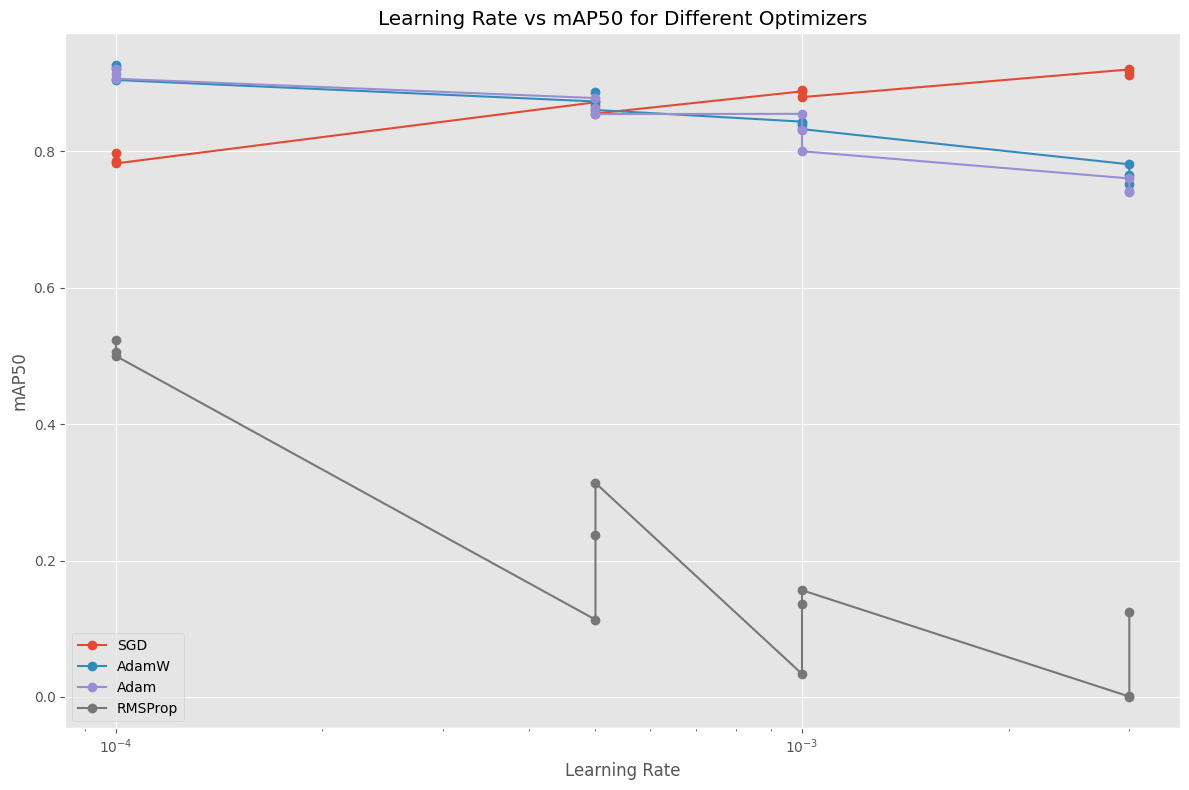

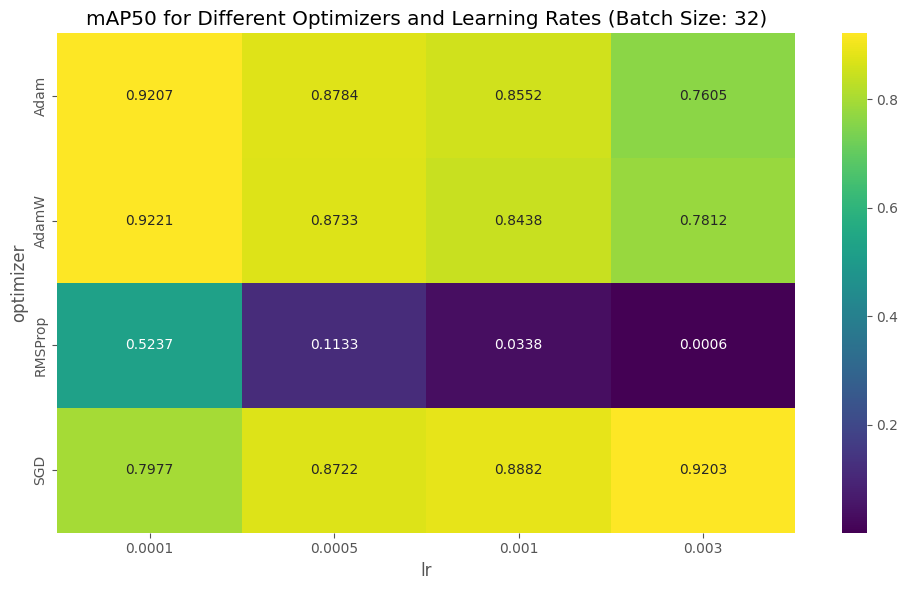

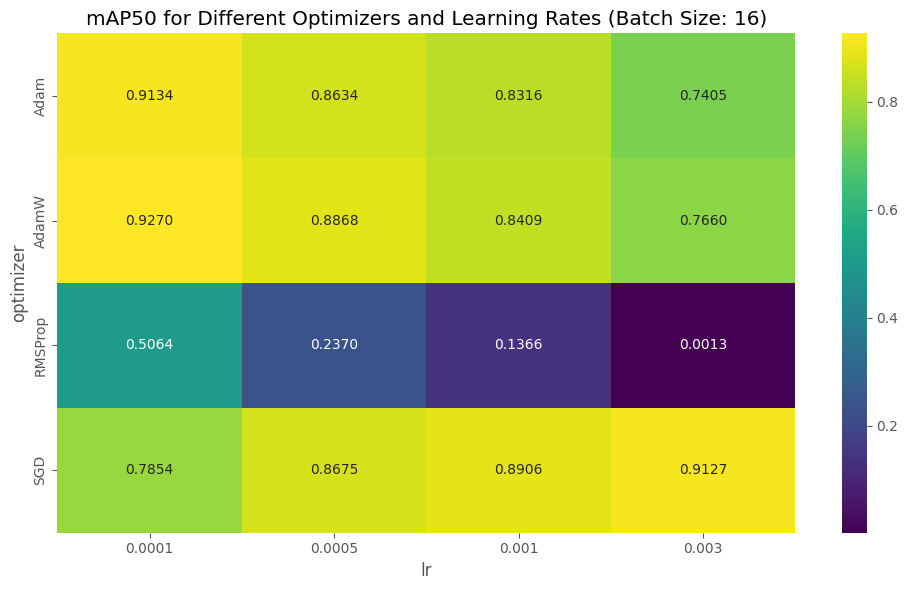

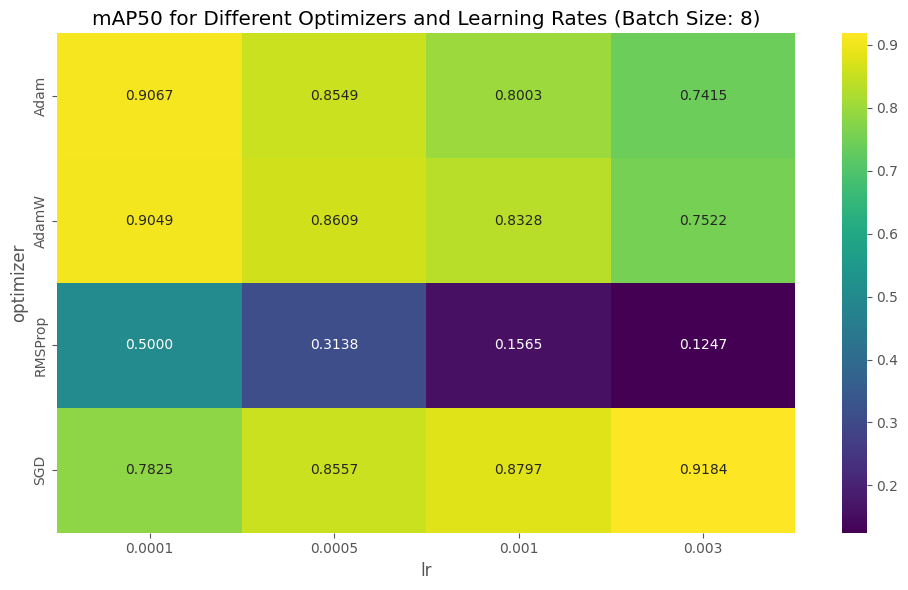

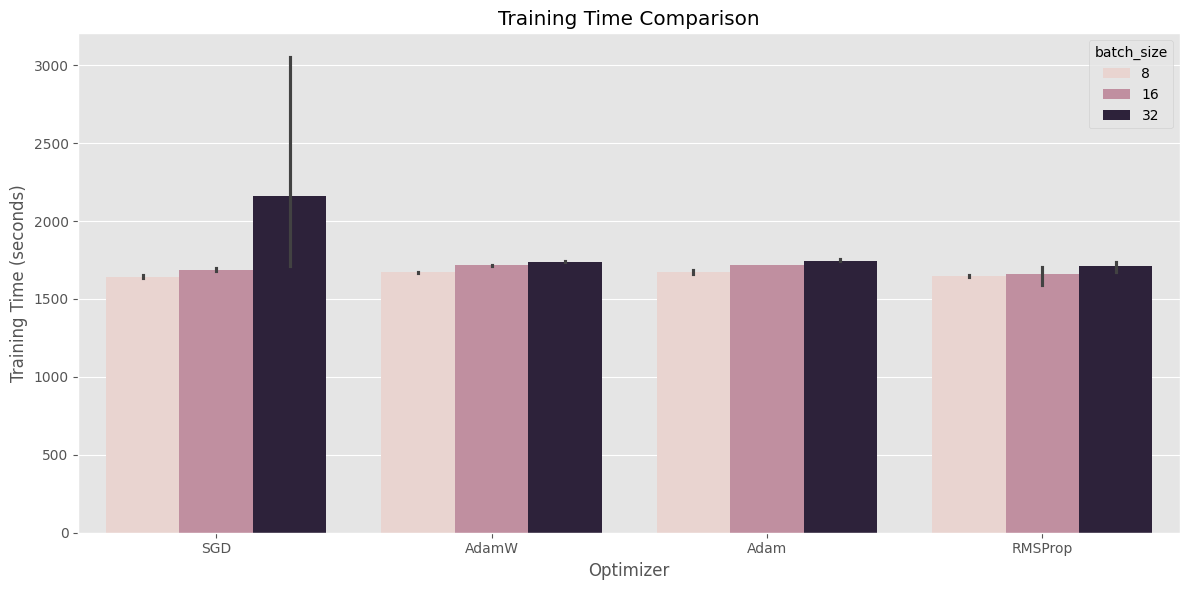

In [ ]:

    # Run grid search
    best_params = run_gridsearch()

    # Find the latest results file
    results_dir = CFG.GRIDSEARCH_DIR
    results_files = [f for f in os.listdir(results_dir) if f.endswith('.csv')]
    latest_results_file = max([os.path.join(results_dir, f) for f in results_files], key=os.path.getmtime)

    # Visualize results
    visualize_results(latest_results_file)

    # # Ask user if they want to train with best parameters
    # user_input = input("\nDo you want to train the final model with the best parameters? (y/n): ")
    # if user_input.lower() in ['y', 'yes']:
    #     final_results = train_with_best_params(best_params)

In [ ]:

torch.cuda.empty_cache()
gc.collect()
print(f"{'='*80}\n")